# 1. Настройки, импорт библиотек

## 1.1 Вывод графиков в ноутбуке

In [1]:
%matplotlib inline

## 1.2 Установка необходимых библиотек

In [1]:
!pip install albumentations
!pip install ipywidgets
!pip install onnx
!pip install onnxscript
!pip install opencv-python
!pip install prettytable
!pip install ultralytics

from IPython import display
display.clear_output()

## 1.3 Импорт библиотек

In [2]:
import albumentations as A
import csv
import cv2
import glob as glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import pandas as pd
import random
import sys
import time
import torch
import torchvision
import ultralytics
import warnings

from albumentations.pytorch import ToTensorV2
from torch.optim import AdamW, SGD
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision.models.detection import (
    fasterrcnn_resnet50_fpn,
    FasterRCNN_ResNet50_FPN_Weights
)
from torchvision.models.detection import (
    fasterrcnn_mobilenet_v3_large_fpn,
    FasterRCNN_MobileNet_V3_Large_FPN_Weights
)
from torchvision.models.detection import (
    ssd300_vgg16,
    SSD300_VGG16_Weights,
    _utils
)
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.ssd import SSDClassificationHead
from tqdm.auto import tqdm
from ultralytics import YOLO, RTDETR

## 1.4 Настройки среды и т.д.

In [3]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.empty_cache()  # Очистка видеокэша PyTorch
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
plt.style.use('ggplot')
ultralytics.checks()
warnings.filterwarnings("ignore")  # Убираем предупреждения

Ultralytics YOLOv8.2.8  Python-3.10.7 torch-2.3.0+cpu CPU (Intel Core(TM) i7-8550U 1.80GHz)
Setup complete  (8 CPUs, 15.9 GB RAM, 245.0/952.6 GB disk)


## 1.5 Проверка доступности `CUDA` и GPU

In [4]:
print('Torch version:', torch.__version__)

if torch.cuda.is_available():    
    print('CUDA is available. Version:', torch.version.cuda)
    print('CUDA device:', torch.cuda.get_device_name(0))
else:
    print('CUDA is not available.')

!nvidia-smi

Torch version: 2.3.0+cpu
CUDA is not available.


"nvidia-smi" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


# 2. Модель `YOLOv9`

## 2.1 Константы, пути, функции модели `YOLOv9`

### 2.1.1 Константы модели `YOLOv9`

In [5]:
EPOCHS = 300    # подобрано опытным путём
IMG_SIZE = 640  # размер изображений датасета (416 для data_folder_1)
BATCH_SIZE = 8  # количество изображений в батче, зависит от размера памяти GPU
LR = 0.001      # начальная скорость обучения (игнорируется при auto оптимизаторе)
# Оптимизатор для тренировки(SGD, Adam, AdamW, NAdam, RAdam, RMSProp, auto),
# влияет на скорость сходимости и стабильность
OPTIMIZER = 'auto'
MODEL_NAME = 'yolov9c_d7_e300'  # имя для хранения обученной модели

### 2.1.2 Пути к папкам и файлам

https://universe.roboflow.com/sunfire-marik-alar9/crime-cctv-object-detection

In [6]:
# Получаем путь к текущей папке /src
# current_dir = os.path.dirname(os.path.abspath(__file__))  # для .py
current_dir = os.getcwd()  # для .ipynb

# Находим папку проекта относительно папки /src
project_path = os.path.abspath(os.path.join(current_dir, os.pardir))
print(f"Путь к папке проекта {project_path}")

# Задаём путь к папке данных относительно папки проекта
# data_folder_0 = os.path.join(project_path, 'theft-detection-97nip2_YOLOv9')
# data_folder_1 = os.path.join(project_path, 'crime-detection-v8i-yolov9')
# data_folder_2 = os.path.join(project_path, 'Crime CCTV Object Detection.v1i.yolov9')
# data_folder_3 = os.path.join(project_path, 'Crime CCTV Object Detection.v2i.yolov9')
# data_folder_4 = os.path.join(project_path, 'Crime CCTV Object Detection.v3i.yolov9')
# data_folder_5 = os.path.join(project_path, 'Crime CCTV Object Detection.v5i.yolov9')
# data_folder_6 = os.path.join(project_path, 'Crime CCTV Object Detection.v6i.yolov9')
data_folder_7 = os.path.join(project_path, 'Crime CCTV Object Detection.v7i.yolov9')
data_folder_8 = os.path.join(project_path, 'Crime CCTV Object Detection.v8i.yolov9')

# Задаём путь к датасету
dataset_file = 'data.yaml'
dataset_path = os.path.join(data_folder_7, dataset_file)
print(f"Путь к датасету {data_folder_7}")

# Задаём путь к текущей моделе
model_path = os.path.join(current_dir, 'runs', 'detect', MODEL_NAME)

# Список  моделей
models = [
    # 'rtdetrl_d7_e300',
    MODEL_NAME,           # текущая модель
    # 'yolov8m_d7_e300',
    # 'yolov8l_d7_e300',
    # 'yolov8n_d7_e300',
    # 'yolov9c_d7_e161',
    # 'yolov9c_d7_e100',
    # 'yolov9_d6_e100',
    # 'yolov9_d5_e100',
    # 'yolov9_d4_e100',
    # 'yolov9_d3_50_s2',  # дообучение 'yolov9_d3_e50_aug'
    # 'yolov9_d3_e50_aug',
    # 'yolov9_d2_e50',
    # 'yolov9_d1_e50_noaug',
    # 'yolov9_d0_e100'
]

# Создание путей к файлам результатов для каждой модели
results_file = 'results.csv'
results_path = {key: os.path.join(current_dir, 'runs', 'detect', key, results_file) for key in models}
print(f"Путь к файлу результатов {results_path[MODEL_NAME]}")

# Для сохранения результатов
best_file = 'best.pt'
output_path = os.path.join(model_path, 'weights', best_file)
print(f"Путь к файлу модели {output_path}")

# Путь к метрикам на тестовой выборке
inference_path = os.path.join(model_path, 'inference')

# Для вывода тестовых результатов
'''
test_file1 = 'Theft--24-_mp4-40_jpg.rf.564b88b5933f327e08d7f7ebdf8c4cde.jpg'  # data_folder_0
test_file2 = 'Theft--41-_mp4-3_jpg.rf.83208eab8d5ff757539623f62b191571.jpg'
test_files = ['burg10_0118_jpg.rf.0254bd0bb0495327ea538559c0447f46.jpg',  # data_folder_1
              'figV_5_0003_jpg.rf.41914284c4850e713aa12f4e4ba7705e.jpg',
              'ROb16_0032_jpg.rf.1c52eb334bed44102d57ff5a3931b0ae.jpg']
test_files = ['burg10_0118_jpg.rf.35badf5be6e43348abdb871202788cb0.jpg',  # data_folder_2 - 3
              'figV_5_0003_jpg.rf.267c49735a53d1544ed6afac051959cc.jpg',
              'ROb16_0032_jpg.rf.86133a8bd41af7b00e3187e3438f0410.jpg']
test_files = ['burg10_0118_jpg.rf.dafbf0189d498ee855f2e3242b98fc22.jpg',  # data_folder_4 - 5
              'figV_5_0003_jpg.rf.bbf327f337e28d84c2bbd87df740277a.jpg',
              'ROb16_0032_jpg.rf.223122dde647aaf56da9531e5fd4a916.jpg']
'''
test_files = ['burg10_0118_jpg.rf.dafbf0189d498ee855f2e3242b98fc22.jpg',  # data_folder_6 - 7
              'figV_5_0003_jpg.rf.8e76dd927944ee7b71037335f5552fb2.jpg',
              'ROb41_0017_jpg.rf.708ca2b763fe3b421d6b5980b1cf25d7.jpg']

test_images_path = os.path.join(project_path, data_folder_8, 'test', 'images')
test_path3 = []
for i in range(3):
    test_path3.append(os.path.join(test_images_path, test_files[i]))

# Для возобновления обучения
last_file = 'last.pt'
resume_path = os.path.join(model_path, 'weights', last_file)

Путь к папке проекта c:\ML\Диплом
Путь к датасету c:\ML\Диплом\Crime CCTV Object Detection.v7i.yolov9
Путь к файлу результатов c:\ML\Диплом\src\runs\detect\yolov9c_d7_e300\results.csv
Путь к файлу модели c:\ML\Диплом\src\runs\detect\yolov9c_d7_e300\weights\best.pt


### 2.1.3 Функции

In [7]:
# Функция для вычисления меры F1
def f1_score_computation(precision, recall):
    f1_score_list = []
    
    for (precision_score, recall_score) in zip(precision, recall):
        try:
            f1_score_list.append(2 * ((precision_score * recall_score) / (precision_score + recall_score)))
        except ZeroDivisionError:
            f1_score_list.append(np.nan)
    
    return f1_score_list

## 2.2 Построение и обучение модели `YOLOv9`

### 2.2.1 Построение модели `YOLOv9` с предварительно обученными весами на датасете `COCO`

In [10]:
model_yolov9 = YOLO('https://github.com/ultralytics/assets/releases/download/v8.1.0/yolov8l.pt')  # для нового обучения
# model_yolov9 = RTDETR('https://github.com/ultralytics/assets/releases/download/v8.2.0/rtdetr-l.pt')  # для нового обучения
# model_yolov9 = YOLO('https://github.com/jameslahm/yolov10/releases/download/v1.0/yolov10b.pt')  # YOLOv10 пока не в Ultralytics
# model_yolov9 = YOLO(resume_path)  # для возобновления обучения
model_yolov9.info()  # для вывода информации о модели

100%|██████████| 63.4M/63.4M [00:06<00:00, 10.9MB/s]


rt-detr-l summary: 673 layers, 32970476 parameters, 0 gradients, 108.3 GFLOPs


(673, 32970476, 0, 108.3437056)

### 2.2.2  Обучение модели `YOLOv9` на выбранном датасете

In [11]:
results_yolov9 = model_yolov9.train(
    data=dataset_path,
    epochs=EPOCHS,
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    lr0=LR,
    optimizer=OPTIMIZER,
    # patience=50,  # сколько эпох ждать без изменения val метрик, полезно при выходе на плато
    plots=True,     # генерирует и сохраняет графики метрик обучения и проверки, примеры предсказаний
    save=True,      # сохранение контрольных точек тренировки и финальных весов модели
    cache=True,     # кэширование изображений наборов данных в памяти
    verbose=True,   # подробный вывод информации во время тренировки
    seed=42,        # для обеспечения воспроизводимости результатов
    val=True,       # валидация во время обучения
    close_mosaic=0, # отключает мозаичную аугментацию данных
    # resume=True,  # для возобновления обучения, иначе - закомментить
    name=MODEL_NAME)

New https://pypi.org/project/ultralytics/8.2.24 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.20 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce RTX 2060, 5927MiB)
engine/trainer: task=detect, mode=train, model=rtdetr-l.pt, data=/home/igor/diplom/Crime CCTV Object Detection.v7i.yolov9/data.yaml, epochs=300, time=None, patience=100, batch=4, imgsz=640, save=True, save_period=-1, cache=True, device=None, workers=8, project=None, name=rtdetrl_d7_e300, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, c

train: Scanning /home/igor/diplom/Crime CCTV Object Detection.v7i.yolov9/train/labels.cache... 3054 images, 150 backgrounds, 0 corrupt: 100%|██████████| 3054/3054 [00:00<?, ?it/s]
train: Caching images (3.5GB RAM): 100%|██████████| 3054/3054 [00:02<00:00, 1212.05it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /home/igor/diplom/Crime CCTV Object Detection.v7i.yolov9/valid/labels.cache... 400 images, 0 backgrounds, 0 corrupt: 100%|██████████| 400/400 [00:00<?, ?it/s]
val: Caching images (0.5GB RAM): 100%|██████████| 400/400 [00:00<00:00, 1184.28it/s]


Plotting labels to runs/detect/rtdetrl_d7_e300/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 143 weight(decay=0.0), 206 weight(decay=0.0005), 226 bias(decay=0.0)


2024/05/29 11:46:27 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2024/05/29 11:46:28 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/05/29 11:46:28 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.
2024/05/29 11:46:28 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.
2024/05/29 11:46:28 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of keras. If you encounter errors during autologging, try upgrading / downgrading keras to a supported version, or try upgrading MLflow.
2024/05/29 11:46:28 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras

MLflow: logging run_id(44643edbde224d01bf068041ebab8e8d) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/rtdetrl_d7_e300
Starting training for 300 epochs...

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


      1/300      4.02G     0.4211      4.462     0.5216          2        640: 100%|██████████| 764/764 [04:25<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  5.96it/s]


                   all        400        520      0.778      0.103     0.0814     0.0461

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


      2/300      3.95G     0.2858     0.7471     0.3433          4        640: 100%|██████████| 764/764 [04:19<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.08it/s]


                   all        400        520      0.208      0.195      0.125     0.0636

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


      3/300      3.83G     0.2439     0.6077     0.2878          5        640: 100%|██████████| 764/764 [04:20<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.06it/s]


                   all        400        520      0.212      0.182      0.136     0.0681

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


      4/300      3.82G     0.2438     0.5922     0.2762          8        640: 100%|██████████| 764/764 [04:19<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.05it/s]


                   all        400        520      0.173      0.164      0.114     0.0517

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


      5/300      3.93G     0.2522      0.571      0.263          4        640: 100%|██████████| 764/764 [04:20<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.04it/s]


                   all        400        520      0.337      0.239      0.219      0.111

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


      6/300      3.84G     0.2461     0.5289     0.2464          8        640: 100%|██████████| 764/764 [04:19<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.04it/s]


                   all        400        520       0.37      0.298      0.273      0.144

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


      7/300      3.84G     0.2494     0.5253     0.2466          4        640: 100%|██████████| 764/764 [04:24<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.01it/s]


                   all        400        520      0.311      0.274      0.218      0.108

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


      8/300      3.84G     0.2345     0.5102     0.2334          5        640: 100%|██████████| 764/764 [04:20<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.06it/s]


                   all        400        520      0.493      0.266      0.242      0.116

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


      9/300      3.92G     0.2323     0.4939     0.2256          3        640: 100%|██████████| 764/764 [04:20<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.04it/s]


                   all        400        520      0.481      0.316      0.286      0.147

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     10/300      3.94G     0.2321     0.4878     0.2196          5        640: 100%|██████████| 764/764 [04:19<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.04it/s]


                   all        400        520      0.524      0.386      0.397      0.216

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     11/300      3.85G     0.2244     0.4724     0.2165          5        640: 100%|██████████| 764/764 [04:19<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.04it/s]


                   all        400        520      0.427      0.383      0.319      0.163

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     12/300      3.83G     0.2255     0.4636     0.2134          3        640: 100%|██████████| 764/764 [04:19<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.02it/s]


                   all        400        520      0.548      0.527      0.528      0.312

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     13/300      3.93G     0.2168     0.4488     0.2116          5        640: 100%|██████████| 764/764 [04:20<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.05it/s]


                   all        400        520      0.524      0.474      0.474      0.266

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     14/300      3.83G     0.2179     0.4449     0.2097          5        640: 100%|██████████| 764/764 [04:20<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.01it/s]


                   all        400        520      0.636      0.418      0.491      0.283

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     15/300      3.83G     0.2162     0.4281     0.2071          8        640: 100%|██████████| 764/764 [04:20<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.04it/s]


                   all        400        520      0.637      0.514      0.547      0.306

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     16/300      3.83G     0.2137     0.4221     0.2013         10        640: 100%|██████████| 764/764 [04:19<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.04it/s]


                   all        400        520      0.626       0.54       0.59      0.341

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     17/300      3.95G     0.2176     0.4304     0.2022          6        640: 100%|██████████| 764/764 [04:20<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.03it/s]


                   all        400        520      0.594      0.501       0.53      0.306

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     18/300      3.83G     0.2204     0.4164     0.2035          9        640: 100%|██████████| 764/764 [04:19<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.06it/s]


                   all        400        520      0.655      0.582      0.637      0.382

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     19/300      3.83G     0.2257     0.4146     0.2146          5        640: 100%|██████████| 764/764 [04:20<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.03it/s]


                   all        400        520      0.669       0.55      0.607      0.354

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     20/300      3.84G     0.2122     0.4036     0.1989          6        640: 100%|██████████| 764/764 [04:21<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.01it/s]


                   all        400        520      0.719      0.554      0.629      0.371

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     21/300      3.92G     0.2155     0.4044      0.203          6        640: 100%|██████████| 764/764 [04:22<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.00it/s]


                   all        400        520      0.657      0.573      0.629      0.346

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     22/300      3.82G     0.2122     0.4037     0.1975          3        640: 100%|██████████| 764/764 [04:22<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.01it/s]


                   all        400        520      0.675      0.561      0.633       0.35

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     23/300      3.83G     0.2133     0.4036     0.1967          4        640: 100%|██████████| 764/764 [04:20<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.01it/s]


                   all        400        520      0.681      0.619      0.661        0.4

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     24/300      3.83G     0.2027     0.3815     0.1885          8        640: 100%|██████████| 764/764 [04:20<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.03it/s]


                   all        400        520      0.712      0.617      0.676      0.375

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     25/300      3.93G     0.2041     0.3825     0.1961          3        640: 100%|██████████| 764/764 [04:19<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.06it/s]


                   all        400        520      0.708      0.638      0.678      0.403

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     26/300      3.86G     0.2118     0.4034      0.192          9        640: 100%|██████████| 764/764 [04:19<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.00it/s]


                   all        400        520      0.667      0.632      0.672      0.394

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     27/300      3.83G     0.1975     0.3848     0.1901          4        640: 100%|██████████| 764/764 [04:20<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.02it/s]


                   all        400        520      0.694      0.585      0.649      0.382

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     28/300      3.85G     0.2017     0.3767     0.1857          6        640: 100%|██████████| 764/764 [04:19<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.03it/s]


                   all        400        520      0.709      0.612      0.689      0.417

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     29/300      3.93G     0.2041     0.3936     0.1932          4        640: 100%|██████████| 764/764 [04:20<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.05it/s]


                   all        400        520       0.69      0.591      0.638       0.37

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     30/300      3.86G     0.2095     0.3823     0.1924          5        640: 100%|██████████| 764/764 [04:20<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.01it/s]


                   all        400        520      0.712      0.588       0.64      0.373

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     31/300      3.86G     0.2058     0.3793     0.1898          3        640: 100%|██████████| 764/764 [04:20<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.02it/s]


                   all        400        520      0.651      0.616      0.686      0.389

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     32/300      3.82G     0.2036     0.3697     0.1889          8        640: 100%|██████████| 764/764 [04:19<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.05it/s]


                   all        400        520      0.724      0.652       0.72      0.437

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     33/300      3.95G        0.2     0.3762     0.1835          4        640: 100%|██████████| 764/764 [04:19<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.02it/s]


                   all        400        520      0.687      0.623      0.684      0.405

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     34/300      3.83G     0.2022     0.3708     0.1868          5        640: 100%|██████████| 764/764 [04:20<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.03it/s]


                   all        400        520      0.737      0.635      0.708      0.415

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     35/300      3.86G     0.2016       0.36     0.1882          5        640: 100%|██████████| 764/764 [04:20<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.03it/s]


                   all        400        520      0.644      0.639      0.665      0.389

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     36/300      3.84G     0.1964     0.3588     0.1864          5        640: 100%|██████████| 764/764 [04:20<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.03it/s]


                   all        400        520      0.739      0.601       0.71      0.426

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     37/300      3.93G     0.1967     0.3609     0.1793          7        640: 100%|██████████| 764/764 [04:20<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.03it/s]


                   all        400        520      0.766       0.64      0.735      0.422

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     38/300       3.9G     0.1951     0.3593       0.18          6        640: 100%|██████████| 764/764 [04:20<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.05it/s]


                   all        400        520      0.741      0.605      0.679      0.416

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     39/300      3.86G      0.192     0.3544     0.1714          6        640: 100%|██████████| 764/764 [04:20<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.02it/s]


                   all        400        520      0.742      0.606      0.705      0.409

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     40/300      3.83G     0.1863     0.3511     0.1686          6        640: 100%|██████████| 764/764 [04:20<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.04it/s]


                   all        400        520      0.739      0.696      0.735       0.45

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     41/300      3.92G     0.1866     0.3472     0.1691          4        640: 100%|██████████| 764/764 [04:19<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.03it/s]


                   all        400        520      0.744      0.654      0.739      0.456

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     42/300      3.87G      0.197     0.3593     0.1738          6        640: 100%|██████████| 764/764 [04:20<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.01it/s]


                   all        400        520      0.713      0.706      0.731      0.436

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     43/300      3.83G     0.1953     0.3609     0.1749          3        640: 100%|██████████| 764/764 [04:20<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  5.99it/s]


                   all        400        520      0.672      0.663      0.697      0.413

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     44/300      3.84G     0.1873     0.3463     0.1741          7        640: 100%|██████████| 764/764 [04:20<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.03it/s]


                   all        400        520       0.77      0.692      0.753       0.47

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     45/300      3.93G     0.1915     0.3548      0.168          7        640: 100%|██████████| 764/764 [04:20<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.01it/s]


                   all        400        520      0.734      0.693      0.735       0.45

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     46/300      3.83G     0.1929      0.351     0.1687          3        640: 100%|██████████| 764/764 [04:21<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.03it/s]


                   all        400        520      0.809      0.647      0.762      0.471

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     47/300      3.83G      0.187     0.3426     0.1671          8        640: 100%|██████████| 764/764 [04:20<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.03it/s]


                   all        400        520        0.8      0.703      0.755      0.464

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     48/300      3.83G     0.1956     0.3444     0.1745          4        640: 100%|██████████| 764/764 [04:19<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.04it/s]


                   all        400        520      0.808      0.669      0.759      0.457

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     49/300      3.93G     0.1754     0.3268     0.1573          6        640: 100%|██████████| 764/764 [04:20<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.01it/s]


                   all        400        520      0.745      0.666       0.71      0.428

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     50/300      3.84G     0.1832     0.3336     0.1616          6        640: 100%|██████████| 764/764 [04:19<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.02it/s]


                   all        400        520      0.735       0.68       0.74      0.453

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     51/300      3.84G     0.1842     0.3383      0.163          2        640: 100%|██████████| 764/764 [04:19<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  5.99it/s]


                   all        400        520      0.811      0.694      0.781      0.485

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     52/300      3.83G     0.1887     0.3378     0.1725          9        640: 100%|██████████| 764/764 [04:20<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.04it/s]


                   all        400        520      0.759      0.703      0.769      0.466

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     53/300      3.93G     0.1794     0.3319     0.1586          5        640: 100%|██████████| 764/764 [04:20<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.03it/s]


                   all        400        520        0.8      0.659      0.751      0.458

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     54/300      3.86G     0.1922     0.3394     0.1666          3        640: 100%|██████████| 764/764 [04:20<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.05it/s]


                   all        400        520      0.746      0.702      0.739      0.465

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     55/300      3.82G     0.1765     0.3225     0.1582          4        640: 100%|██████████| 764/764 [04:19<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.04it/s]


                   all        400        520      0.804      0.647      0.746      0.452

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     56/300      3.84G     0.1862     0.3412     0.1648          8        640: 100%|██████████| 764/764 [04:20<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.05it/s]


                   all        400        520      0.798      0.651      0.735      0.454

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     57/300      3.95G     0.1767     0.3262     0.1586          6        640: 100%|██████████| 764/764 [04:20<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.04it/s]


                   all        400        520      0.789       0.68      0.753       0.45

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     58/300      3.83G     0.1838     0.3246      0.162          6        640: 100%|██████████| 764/764 [04:20<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.01it/s]


                   all        400        520      0.807      0.698      0.772      0.452

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     59/300      3.86G     0.1805      0.324     0.1644          8        640: 100%|██████████| 764/764 [04:20<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.03it/s]


                   all        400        520      0.818      0.643       0.74       0.44

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     60/300      3.85G     0.1663     0.3176      0.151          7        640: 100%|██████████| 764/764 [04:20<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.02it/s]


                   all        400        520      0.769      0.722      0.777      0.456

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     61/300      3.95G     0.1629     0.3072     0.1529          4        640: 100%|██████████| 764/764 [04:19<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.04it/s]


                   all        400        520       0.79      0.711      0.781      0.486

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     62/300      3.83G     0.1807      0.329     0.1533          6        640: 100%|██████████| 764/764 [04:19<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.00it/s]


                   all        400        520      0.769      0.725      0.783      0.466

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     63/300      3.83G     0.1614     0.3085     0.1458         11        640: 100%|██████████| 764/764 [04:19<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.00it/s]


                   all        400        520      0.754      0.698      0.761      0.459

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     64/300      3.83G      0.168     0.3163     0.1487          6        640: 100%|██████████| 764/764 [04:19<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.03it/s]


                   all        400        520      0.845      0.675      0.801      0.494

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     65/300      3.93G     0.1652     0.3131     0.1448          4        640: 100%|██████████| 764/764 [04:20<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  5.98it/s]


                   all        400        520      0.788      0.708      0.785      0.496

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     66/300      3.86G      0.176     0.3188     0.1528          5        640: 100%|██████████| 764/764 [04:21<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.03it/s]


                   all        400        520      0.766      0.722      0.774      0.479

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     67/300      3.83G      0.186     0.3211     0.1603          7        640: 100%|██████████| 764/764 [04:18<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.00it/s]


                   all        400        520      0.783      0.731      0.796      0.494

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     68/300      3.81G     0.1693     0.3077     0.1529          7        640: 100%|██████████| 764/764 [04:19<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.05it/s]


                   all        400        520       0.81      0.691      0.779      0.486

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     69/300      3.92G     0.1748     0.3153     0.1584          7        640: 100%|██████████| 764/764 [04:20<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.03it/s]


                   all        400        520      0.768      0.694      0.761      0.467

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     70/300      3.83G     0.1603     0.2993     0.1453          4        640: 100%|██████████| 764/764 [04:20<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.04it/s]


                   all        400        520      0.758      0.678      0.756      0.437

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     71/300      3.83G     0.1613     0.3004      0.142          8        640: 100%|██████████| 764/764 [04:19<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.01it/s]


                   all        400        520      0.803       0.71       0.78      0.485

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     72/300      3.84G     0.1566     0.2977      0.139          4        640: 100%|██████████| 764/764 [04:20<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.03it/s]


                   all        400        520      0.774      0.693      0.747      0.456

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     73/300      3.94G     0.1708     0.3136     0.1483         10        640: 100%|██████████| 764/764 [04:20<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.04it/s]


                   all        400        520      0.783      0.748      0.785      0.485

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     74/300      3.84G     0.1605     0.2956     0.1438         10        640: 100%|██████████| 764/764 [04:19<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.03it/s]


                   all        400        520      0.837      0.705      0.792      0.485

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     75/300      3.83G     0.1607     0.2959     0.1432          5        640: 100%|██████████| 764/764 [04:19<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.04it/s]


                   all        400        520      0.828      0.698      0.782      0.487

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     76/300      3.83G     0.1617      0.304     0.1409          7        640: 100%|██████████| 764/764 [04:20<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.02it/s]


                   all        400        520      0.808      0.734      0.792      0.498

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     77/300      3.93G     0.1689     0.3108     0.1483          6        640: 100%|██████████| 764/764 [04:19<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  5.99it/s]


                   all        400        520      0.801      0.705      0.774       0.49

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     78/300      3.83G     0.1583     0.2938      0.139          2        640: 100%|██████████| 764/764 [04:19<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.04it/s]


                   all        400        520      0.763      0.741      0.786      0.467

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     79/300      3.86G     0.1642     0.2961     0.1401          5        640: 100%|██████████| 764/764 [04:21<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.00it/s]


                   all        400        520      0.798      0.685      0.761      0.474

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     80/300      3.84G      0.155     0.2942     0.1378          4        640: 100%|██████████| 764/764 [04:20<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.01it/s]


                   all        400        520      0.795      0.691      0.773      0.472

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     81/300      3.93G     0.1595     0.2993     0.1429          3        640: 100%|██████████| 764/764 [04:20<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  5.98it/s]


                   all        400        520        0.8      0.723      0.794      0.499

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     82/300      3.86G      0.166     0.3116     0.1415          5        640: 100%|██████████| 764/764 [04:19<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.03it/s]


                   all        400        520      0.826      0.683      0.776      0.487

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     83/300      3.83G     0.1758      0.316     0.1454          7        640: 100%|██████████| 764/764 [04:20<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.00it/s]


                   all        400        520      0.813      0.715       0.79       0.51

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     84/300      3.83G     0.1525     0.2872     0.1344          4        640: 100%|██████████| 764/764 [04:20<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.03it/s]


                   all        400        520      0.801      0.699      0.778      0.478

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     85/300      3.93G     0.1468     0.2835      0.129          6        640: 100%|██████████| 764/764 [04:20<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.02it/s]


                   all        400        520      0.789      0.687      0.754      0.486

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     86/300      3.83G     0.1714     0.3066     0.1465          4        640: 100%|██████████| 764/764 [04:20<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.00it/s]


                   all        400        520      0.804      0.741      0.803      0.482

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     87/300      3.83G     0.1526     0.2814     0.1311          6        640: 100%|██████████| 764/764 [04:19<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.01it/s]


                   all        400        520      0.824      0.703      0.772      0.482

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     88/300      3.86G      0.156     0.2883      0.132          8        640: 100%|██████████| 764/764 [04:20<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.02it/s]


                   all        400        520      0.808      0.723      0.782      0.507

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     89/300      3.96G     0.1487     0.2834      0.131          6        640: 100%|██████████| 764/764 [04:19<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.02it/s]


                   all        400        520      0.788      0.718      0.778      0.494

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     90/300      3.86G     0.1495     0.2855      0.129          7        640: 100%|██████████| 764/764 [04:20<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.02it/s]


                   all        400        520      0.798      0.745      0.789      0.494

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     91/300      3.83G     0.1477     0.2859     0.1303          6        640: 100%|██████████| 764/764 [04:21<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.03it/s]


                   all        400        520      0.838      0.717      0.791      0.498

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     92/300      3.83G     0.1569     0.2917     0.1333          4        640: 100%|██████████| 764/764 [04:19<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.01it/s]


                   all        400        520      0.828      0.732      0.811      0.507

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     93/300      3.94G     0.1515     0.2812     0.1322          5        640: 100%|██████████| 764/764 [04:19<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.05it/s]


                   all        400        520      0.795      0.737      0.797      0.492

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     94/300      3.83G     0.1608     0.2935     0.1336          6        640: 100%|██████████| 764/764 [04:19<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.04it/s]


                   all        400        520      0.768      0.743      0.789      0.471

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     95/300      3.83G     0.1506     0.2748      0.127          7        640: 100%|██████████| 764/764 [04:20<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.00it/s]


                   all        400        520      0.828      0.693      0.788      0.496

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     96/300      3.84G     0.1543      0.283     0.1322          6        640: 100%|██████████| 764/764 [04:20<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.02it/s]


                   all        400        520      0.835      0.711      0.805      0.507

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     97/300      3.94G     0.1467      0.277     0.1298          4        640: 100%|██████████| 764/764 [04:20<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.02it/s]


                   all        400        520      0.792      0.746      0.816      0.515

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     98/300      3.87G     0.1538     0.2874     0.1286          6        640: 100%|██████████| 764/764 [04:19<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.03it/s]


                   all        400        520      0.825       0.75       0.82      0.526

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     99/300      3.83G     0.1362     0.2642      0.123          6        640: 100%|██████████| 764/764 [04:19<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.03it/s]


                   all        400        520      0.832       0.73      0.804      0.518

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    100/300      3.83G     0.1421     0.2643     0.1266          2        640: 100%|██████████| 764/764 [04:19<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.04it/s]


                   all        400        520      0.822       0.75      0.815      0.534

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    101/300      3.92G     0.1615     0.2853     0.1328          4        640: 100%|██████████| 764/764 [04:20<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.00it/s]


                   all        400        520      0.798      0.744      0.813      0.505

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    102/300      3.83G     0.1424      0.268     0.1226          4        640: 100%|██████████| 764/764 [04:19<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.02it/s]


                   all        400        520      0.764       0.79      0.815      0.505

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    103/300      3.83G     0.1508     0.2792     0.1308          4        640: 100%|██████████| 764/764 [04:19<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.01it/s]


                   all        400        520      0.825      0.768      0.817      0.516

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    104/300      3.83G     0.1351     0.2598     0.1206          5        640: 100%|██████████| 764/764 [04:19<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.05it/s]


                   all        400        520      0.856      0.706        0.8      0.501

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    105/300      3.93G     0.1452     0.2668     0.1226          8        640: 100%|██████████| 764/764 [04:20<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.06it/s]


                   all        400        520      0.801      0.739      0.805      0.492

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    106/300      3.86G     0.1572     0.2837     0.1309          7        640: 100%|██████████| 764/764 [04:20<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.03it/s]


                   all        400        520       0.83      0.744      0.821      0.522

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    107/300      3.83G      0.139     0.2633     0.1172          7        640: 100%|██████████| 764/764 [04:20<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.01it/s]


                   all        400        520      0.814      0.752       0.82      0.527

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    108/300      3.83G     0.1308     0.2561      0.115          5        640: 100%|██████████| 764/764 [04:20<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.02it/s]


                   all        400        520      0.794      0.745        0.8      0.512

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    109/300       3.9G      0.141     0.2663      0.122          9        640: 100%|██████████| 764/764 [04:20<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.00it/s]


                   all        400        520      0.801       0.71       0.79      0.505

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    110/300      3.83G      0.135     0.2584     0.1136          3        640: 100%|██████████| 764/764 [04:19<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.02it/s]


                   all        400        520      0.816      0.722      0.799      0.503

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    111/300      3.84G     0.1402     0.2684     0.1184          7        640: 100%|██████████| 764/764 [04:20<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.04it/s]


                   all        400        520      0.845      0.708      0.797      0.505

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    112/300      3.83G     0.1438     0.2684     0.1194          8        640: 100%|██████████| 764/764 [04:20<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.03it/s]


                   all        400        520      0.817      0.792      0.824      0.522

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    113/300      3.94G     0.1339     0.2586     0.1148          6        640: 100%|██████████| 764/764 [04:19<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.00it/s]


                   all        400        520      0.818      0.744      0.809      0.507

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    114/300      3.83G     0.1384     0.2626      0.115          3        640: 100%|██████████| 764/764 [04:20<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.05it/s]


                   all        400        520      0.834      0.738      0.825      0.523

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    115/300      3.83G      0.131      0.255     0.1118          8        640: 100%|██████████| 764/764 [04:20<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.04it/s]


                   all        400        520      0.851      0.719        0.8      0.494

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    116/300      3.83G     0.1393      0.265     0.1175          2        640: 100%|██████████| 764/764 [04:20<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.02it/s]


                   all        400        520      0.799      0.749      0.806      0.487

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    117/300      3.96G     0.1383      0.261     0.1135          7        640: 100%|██████████| 764/764 [04:19<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.03it/s]


                   all        400        520      0.806      0.728      0.805      0.494

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    118/300      3.83G     0.1338     0.2606     0.1131          4        640: 100%|██████████| 764/764 [04:20<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  5.99it/s]


                   all        400        520      0.804      0.763      0.815       0.51

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    119/300      3.84G     0.1272     0.2465     0.1117          3        640: 100%|██████████| 764/764 [04:20<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.03it/s]


                   all        400        520      0.851      0.766      0.824      0.525

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    120/300      3.84G     0.1569     0.2849     0.1289          7        640: 100%|██████████| 764/764 [04:20<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.04it/s]


                   all        400        520      0.801      0.768      0.805      0.509

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    121/300      3.96G     0.1219     0.2475      0.105          7        640: 100%|██████████| 764/764 [04:20<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.03it/s]


                   all        400        520       0.81      0.729      0.789      0.495

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    122/300      3.83G      0.127     0.2512     0.1089          4        640: 100%|██████████| 764/764 [04:20<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.03it/s]


                   all        400        520      0.842      0.739      0.816       0.52

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    123/300      3.83G     0.1323     0.2621     0.1129          6        640: 100%|██████████| 764/764 [04:20<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.04it/s]


                   all        400        520      0.804       0.77      0.817      0.529

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    124/300      3.85G      0.132     0.2543      0.112          6        640: 100%|██████████| 764/764 [04:21<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.03it/s]


                   all        400        520      0.849      0.749      0.818      0.534

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    125/300      3.93G     0.1287     0.2552     0.1086          7        640: 100%|██████████| 764/764 [04:20<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.03it/s]


                   all        400        520      0.811      0.726      0.784      0.503

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    126/300      3.83G     0.1229     0.2455     0.1062          7        640: 100%|██████████| 764/764 [04:20<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.02it/s]


                   all        400        520      0.814      0.719      0.805      0.515

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    127/300      3.83G     0.1235     0.2426     0.1058          4        640: 100%|██████████| 764/764 [04:20<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.02it/s]


                   all        400        520      0.848       0.74      0.815      0.524

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    128/300      3.83G     0.1326      0.256     0.1093          6        640: 100%|██████████| 764/764 [04:20<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.03it/s]


                   all        400        520      0.812      0.739      0.801      0.517

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    129/300      3.91G     0.1334     0.2574     0.1135          7        640: 100%|██████████| 764/764 [04:19<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.04it/s]


                   all        400        520      0.833      0.761      0.811      0.497

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    130/300      3.92G     0.1236     0.2461      0.105          7        640: 100%|██████████| 764/764 [04:20<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.00it/s]


                   all        400        520        0.8      0.771      0.814       0.51

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    131/300      3.84G     0.1255     0.2453     0.1081          6        640: 100%|██████████| 764/764 [04:20<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.06it/s]


                   all        400        520      0.801      0.792      0.818      0.508

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    132/300      3.83G     0.1329     0.2552     0.1091          7        640: 100%|██████████| 764/764 [04:20<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.03it/s]


                   all        400        520      0.783      0.774      0.814      0.515

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    133/300      3.94G       0.12     0.2382     0.1042          6        640: 100%|██████████| 764/764 [04:20<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.04it/s]


                   all        400        520      0.865      0.717      0.813      0.517

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    134/300      3.85G     0.1234      0.241     0.1054          6        640: 100%|██████████| 764/764 [04:20<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.03it/s]


                   all        400        520      0.819      0.737      0.806      0.509

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    135/300      3.84G     0.1199     0.2398      0.105          4        640: 100%|██████████| 764/764 [04:20<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.02it/s]


                   all        400        520      0.823       0.73      0.796      0.515

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    136/300      3.83G     0.1156     0.2335    0.09683          3        640: 100%|██████████| 764/764 [04:20<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.04it/s]


                   all        400        520      0.821      0.743      0.806      0.525

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    137/300      3.93G      0.126     0.2445     0.1026          4        640: 100%|██████████| 764/764 [04:21<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.01it/s]


                   all        400        520      0.801      0.769      0.808      0.525

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    138/300      3.84G     0.1277     0.2443     0.1051          8        640: 100%|██████████| 764/764 [04:20<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.04it/s]


                   all        400        520      0.843      0.725      0.805      0.513

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    139/300      3.83G     0.1252     0.2419     0.1058          9        640: 100%|██████████| 764/764 [04:20<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.06it/s]


                   all        400        520      0.835      0.763      0.807      0.524

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    140/300      3.83G     0.1165      0.232     0.1015          3        640: 100%|██████████| 764/764 [04:19<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.01it/s]


                   all        400        520      0.826      0.728      0.795      0.514

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    141/300      3.95G     0.1105     0.2247    0.09694          9        640: 100%|██████████| 764/764 [04:20<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.01it/s]


                   all        400        520      0.822      0.751      0.805      0.531

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    142/300      3.86G     0.1205     0.2379     0.1042          4        640: 100%|██████████| 764/764 [04:20<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.01it/s]


                   all        400        520      0.827      0.745      0.807      0.526

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    143/300      3.84G     0.1271     0.2427     0.1084          5        640: 100%|██████████| 764/764 [04:20<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.03it/s]


                   all        400        520      0.809      0.761      0.788      0.511

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    144/300      3.86G     0.1169     0.2374     0.0973          4        640: 100%|██████████| 764/764 [04:19<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.03it/s]


                   all        400        520      0.825      0.728      0.795      0.514

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    145/300      3.93G     0.1149     0.2293    0.09472          3        640: 100%|██████████| 764/764 [04:19<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.02it/s]


                   all        400        520       0.81      0.742      0.791      0.525

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    146/300      3.85G     0.1176     0.2376    0.09834          5        640: 100%|██████████| 764/764 [04:20<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.05it/s]


                   all        400        520      0.839      0.715        0.8      0.527

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    147/300      3.83G     0.1168     0.2315    0.09759          6        640: 100%|██████████| 764/764 [04:19<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.02it/s]


                   all        400        520      0.823      0.729      0.796       0.52

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    148/300      3.83G     0.1169     0.2391    0.09863          3        640: 100%|██████████| 764/764 [04:20<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.04it/s]


                   all        400        520      0.828      0.737      0.805      0.524

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    149/300      3.91G     0.1161     0.2328     0.0991          6        640: 100%|██████████| 764/764 [04:19<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.00it/s]


                   all        400        520      0.784      0.759      0.798      0.516

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    150/300      3.92G     0.1112     0.2252    0.09472         12        640: 100%|██████████| 764/764 [04:19<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.04it/s]


                   all        400        520      0.814      0.744      0.806      0.519

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    151/300      3.81G     0.1105     0.2223    0.09448          5        640: 100%|██████████| 764/764 [04:20<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.01it/s]


                   all        400        520      0.855      0.723      0.807      0.516

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    152/300      3.82G     0.1195     0.2337    0.09917          5        640: 100%|██████████| 764/764 [04:18<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.04it/s]


                   all        400        520      0.848       0.73      0.802      0.513

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    153/300      3.95G     0.1172     0.2345    0.09675          5        640: 100%|██████████| 764/764 [04:18<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.07it/s]


                   all        400        520      0.862      0.737      0.806      0.524

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    154/300      3.84G     0.1071     0.2145    0.08972          3        640: 100%|██████████| 764/764 [04:18<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.02it/s]


                   all        400        520      0.807      0.779      0.818      0.526

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    155/300      3.83G     0.1185     0.2255    0.09908          9        640: 100%|██████████| 764/764 [04:18<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.00it/s]


                   all        400        520      0.826      0.756      0.814      0.521

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    156/300      3.82G     0.1154     0.2272    0.09527          5        640: 100%|██████████| 764/764 [04:19<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.03it/s]


                   all        400        520      0.818      0.776       0.82      0.534

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    157/300      3.93G     0.1104     0.2259    0.09255          6        640: 100%|██████████| 764/764 [04:19<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.08it/s]


                   all        400        520      0.829      0.759      0.817      0.536

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    158/300      3.86G      0.103     0.2134    0.08723          5        640: 100%|██████████| 764/764 [04:18<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.04it/s]


                   all        400        520       0.84      0.743       0.81      0.534

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    159/300      3.83G     0.1025     0.2026    0.08462          3        640: 100%|██████████| 764/764 [04:19<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.04it/s]


                   all        400        520      0.823      0.756      0.808      0.525

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    160/300      3.83G     0.1124     0.2222    0.09382          6        640: 100%|██████████| 764/764 [04:19<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.07it/s]


                   all        400        520       0.85      0.756      0.815      0.533

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    161/300      3.94G     0.1059     0.2142    0.08807          7        640: 100%|██████████| 764/764 [04:19<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.07it/s]


                   all        400        520      0.846      0.741      0.826       0.54

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    162/300      3.87G     0.1008     0.2038    0.08703          8        640: 100%|██████████| 764/764 [04:18<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.05it/s]


                   all        400        520      0.787      0.733      0.805       0.53

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    163/300      3.83G     0.1042      0.219    0.08805          8        640: 100%|██████████| 764/764 [04:19<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.06it/s]


                   all        400        520      0.828      0.725      0.806      0.533

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    164/300      3.83G     0.1036     0.2113    0.08857          6        640: 100%|██████████| 764/764 [04:18<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.05it/s]


                   all        400        520      0.853      0.723       0.81      0.536

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    165/300      3.96G     0.1043     0.2096     0.0884          4        640: 100%|██████████| 764/764 [04:19<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.04it/s]


                   all        400        520      0.811      0.771      0.812      0.534

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    166/300      3.86G     0.1047     0.2129    0.08865          8        640: 100%|██████████| 764/764 [04:18<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.04it/s]


                   all        400        520      0.838      0.737      0.813      0.537

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    167/300      3.91G    0.09842     0.2081    0.08274          6        640: 100%|██████████| 764/764 [04:19<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.05it/s]


                   all        400        520      0.835      0.758      0.815      0.525

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    168/300      3.85G    0.09593     0.2011    0.08257          6        640: 100%|██████████| 764/764 [04:19<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.06it/s]


                   all        400        520      0.847      0.747       0.82      0.541

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    169/300      3.93G     0.1007     0.2093    0.08511          7        640: 100%|██████████| 764/764 [04:19<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.02it/s]


                   all        400        520      0.843       0.76       0.82      0.543

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    170/300      3.84G     0.1035     0.2119    0.08674          7        640: 100%|██████████| 764/764 [04:18<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.03it/s]


                   all        400        520      0.822      0.745      0.817      0.549

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    171/300      3.84G     0.1012     0.2104    0.08447          4        640: 100%|██████████| 764/764 [04:18<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.06it/s]


                   all        400        520       0.84      0.741      0.815      0.542

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    172/300      3.84G     0.0983     0.2021    0.08265          7        640: 100%|██████████| 764/764 [04:18<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.04it/s]


                   all        400        520      0.834      0.753      0.807      0.537

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    173/300      3.96G    0.09557     0.2004    0.08253          3        640: 100%|██████████| 764/764 [04:18<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.05it/s]


                   all        400        520      0.835      0.765      0.811      0.539

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    174/300      3.83G     0.1033     0.2132    0.08349          5        640: 100%|██████████| 764/764 [04:18<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.04it/s]


                   all        400        520      0.831      0.744      0.801      0.531

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    175/300      3.84G    0.09816     0.2045    0.08169          5        640: 100%|██████████| 764/764 [04:17<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.02it/s]


                   all        400        520      0.859      0.725      0.803      0.535

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    176/300      3.85G    0.09557     0.1961    0.07987          3        640: 100%|██████████| 764/764 [04:18<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.06it/s]


                   all        400        520      0.858      0.738      0.804      0.535

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    177/300      3.95G    0.09731     0.2067    0.08102          9        640: 100%|██████████| 764/764 [04:18<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.06it/s]


                   all        400        520      0.839      0.746      0.798      0.534

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    178/300      3.84G    0.09699     0.2065    0.07882          7        640: 100%|██████████| 764/764 [04:18<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.05it/s]


                   all        400        520      0.841      0.739      0.802      0.531

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    179/300      3.82G     0.0959     0.2022    0.07805          6        640: 100%|██████████| 764/764 [04:18<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.07it/s]


                   all        400        520      0.831      0.742        0.8      0.529

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    180/300      3.86G     0.1041     0.2122     0.0821          9        640: 100%|██████████| 764/764 [04:18<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.07it/s]


                   all        400        520      0.828      0.755      0.801      0.529

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    181/300      3.92G     0.1004     0.2034    0.08051          8        640: 100%|██████████| 764/764 [04:18<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.05it/s]


                   all        400        520      0.859       0.73      0.818      0.538

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    182/300      3.82G    0.09231     0.1958    0.07674          3        640: 100%|██████████| 764/764 [04:18<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.05it/s]


                   all        400        520      0.837      0.762      0.816      0.533

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    183/300      3.83G    0.09498     0.1979    0.07879          4        640: 100%|██████████| 764/764 [04:19<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.08it/s]


                   all        400        520      0.824      0.758      0.812       0.53

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    184/300      3.83G    0.09445     0.1938    0.07846          6        640: 100%|██████████| 764/764 [04:18<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.09it/s]


                   all        400        520      0.865      0.745      0.815      0.542

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    185/300      3.93G    0.09444     0.1974    0.08094          3        640: 100%|██████████| 764/764 [04:18<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.06it/s]


                   all        400        520      0.873       0.75      0.826      0.544

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    186/300      3.83G    0.09257     0.1985    0.07735          7        640: 100%|██████████| 764/764 [04:18<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.06it/s]


                   all        400        520      0.842      0.775      0.839      0.549

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    187/300      3.83G    0.09552     0.2055    0.07918         11        640: 100%|██████████| 764/764 [04:18<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.04it/s]


                   all        400        520      0.859      0.765      0.833      0.549

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    188/300      3.85G    0.09268     0.1955    0.07839          7        640: 100%|██████████| 764/764 [04:17<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.06it/s]


                   all        400        520      0.874      0.761      0.839      0.549

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    189/300       3.9G    0.08722     0.1911    0.07257          8        640: 100%|██████████| 764/764 [04:17<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.05it/s]


                   all        400        520      0.882      0.765      0.842      0.556

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    190/300      3.83G    0.08677     0.1826    0.07201          3        640: 100%|██████████| 764/764 [04:17<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.08it/s]


                   all        400        520      0.877      0.782      0.845       0.56

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    191/300      3.84G    0.08713     0.1897    0.07144          7        640: 100%|██████████| 764/764 [04:18<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.07it/s]


                   all        400        520      0.882      0.763      0.846      0.561

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    192/300      3.83G    0.08385     0.1857     0.0696          7        640: 100%|██████████| 764/764 [04:18<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.07it/s]


                   all        400        520      0.874      0.768       0.84      0.558

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    193/300      3.95G    0.09222      0.193    0.07387         11        640: 100%|██████████| 764/764 [04:18<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.05it/s]


                   all        400        520      0.866      0.782      0.843      0.557

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    194/300      3.83G    0.08972     0.1915    0.07354          6        640: 100%|██████████| 764/764 [04:17<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.08it/s]


                   all        400        520       0.87      0.781       0.84      0.553

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    195/300      3.84G    0.08165     0.1792    0.06855          7        640: 100%|██████████| 764/764 [04:18<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.08it/s]


                   all        400        520      0.855      0.782      0.833       0.55

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    196/300      3.83G    0.08611     0.1865    0.07159          8        640: 100%|██████████| 764/764 [04:18<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.07it/s]


                   all        400        520      0.849      0.786      0.835       0.55

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    197/300      3.96G    0.08478     0.1796    0.06996          5        640: 100%|██████████| 764/764 [04:18<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.06it/s]


                   all        400        520      0.831       0.78      0.832      0.556

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    198/300      3.82G    0.08765     0.1873    0.07155          6        640: 100%|██████████| 764/764 [04:17<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.05it/s]


                   all        400        520      0.883      0.732      0.829      0.559

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    199/300      3.82G    0.08687      0.189    0.07086          6        640: 100%|██████████| 764/764 [04:17<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.05it/s]


                   all        400        520      0.895       0.73      0.832      0.563

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    200/300      3.83G    0.08449     0.1792    0.07037          5        640: 100%|██████████| 764/764 [04:17<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.07it/s]


                   all        400        520      0.892      0.741      0.834      0.563

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    201/300      3.93G    0.08244     0.1772    0.06811         11        640: 100%|██████████| 764/764 [04:17<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.09it/s]


                   all        400        520      0.884      0.736      0.829      0.563

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    202/300      3.86G    0.08055     0.1728    0.06739          4        640: 100%|██████████| 764/764 [04:17<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.08it/s]


                   all        400        520      0.865      0.752      0.824      0.561

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    203/300      3.83G    0.08137     0.1745    0.06723          8        640: 100%|██████████| 764/764 [04:18<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.09it/s]


                   all        400        520      0.848      0.775      0.824      0.559

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    204/300      3.83G     0.0835     0.1797    0.06904          4        640: 100%|██████████| 764/764 [04:18<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.08it/s]


                   all        400        520      0.867      0.756      0.822      0.561

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    205/300      3.93G    0.08338     0.1803    0.06737          8        640: 100%|██████████| 764/764 [04:18<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.05it/s]


                   all        400        520      0.866      0.778      0.829      0.559

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    206/300      3.87G    0.08083     0.1757    0.06786          8        640: 100%|██████████| 764/764 [04:17<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.08it/s]


                   all        400        520      0.881       0.77      0.828      0.556

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    207/300      3.82G    0.08084     0.1716    0.06785          9        640: 100%|██████████| 764/764 [04:17<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.10it/s]


                   all        400        520      0.868      0.773      0.824      0.559

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    208/300      3.83G    0.07987      0.173    0.06934          2        640: 100%|██████████| 764/764 [04:17<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.06it/s]


                   all        400        520      0.871      0.774      0.826      0.558

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    209/300      3.94G    0.08102     0.1766    0.06637          6        640: 100%|██████████| 764/764 [04:17<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.09it/s]


                   all        400        520      0.862      0.779      0.828      0.554

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    210/300      3.83G    0.08109      0.178    0.06818          7        640: 100%|██████████| 764/764 [04:17<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.07it/s]


                   all        400        520      0.875      0.772      0.833      0.556

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    211/300      3.83G    0.07708     0.1718    0.06602          8        640: 100%|██████████| 764/764 [04:17<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.08it/s]


                   all        400        520      0.878       0.77      0.828      0.554

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    212/300      3.91G    0.08217     0.1723    0.06701          8        640: 100%|██████████| 764/764 [04:17<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.05it/s]


                   all        400        520      0.851      0.783      0.828       0.55

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    213/300      3.93G    0.07619     0.1677    0.06372          6        640: 100%|██████████| 764/764 [04:18<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.10it/s]


                   all        400        520       0.84      0.791      0.825      0.549

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    214/300      3.84G    0.07551     0.1645     0.0627          4        640: 100%|██████████| 764/764 [04:17<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.09it/s]


                   all        400        520      0.849      0.787      0.819      0.549

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    215/300      3.83G    0.07124     0.1634    0.05986          3        640: 100%|██████████| 764/764 [04:18<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.05it/s]


                   all        400        520      0.861      0.773      0.822      0.552

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    216/300      3.84G    0.07497     0.1627    0.06094          5        640: 100%|██████████| 764/764 [04:17<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.08it/s]


                   all        400        520       0.85      0.777      0.821      0.557

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    217/300      3.93G    0.07201     0.1612     0.0597          3        640: 100%|██████████| 764/764 [04:18<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.07it/s]


                   all        400        520      0.845      0.775       0.82      0.556

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    218/300      3.84G    0.08051     0.1706    0.06501          8        640: 100%|██████████| 764/764 [04:18<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.05it/s]


                   all        400        520      0.838       0.79      0.821      0.555

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    219/300      3.86G    0.07618     0.1677    0.06326          7        640: 100%|██████████| 764/764 [04:18<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.07it/s]


                   all        400        520      0.842      0.768      0.817      0.551

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    220/300      3.83G    0.07218       0.16     0.0615          9        640: 100%|██████████| 764/764 [04:17<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.08it/s]


                   all        400        520      0.849      0.772      0.827      0.554

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    221/300      3.94G    0.07189     0.1614    0.06103          7        640: 100%|██████████| 764/764 [04:16<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.08it/s]


                   all        400        520      0.866      0.762      0.831      0.556

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    222/300      3.83G    0.07235     0.1629    0.06039          6        640: 100%|██████████| 764/764 [04:18<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.07it/s]


                   all        400        520      0.851      0.776      0.836      0.563

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    223/300      3.86G    0.07015     0.1582    0.05729          5        640: 100%|██████████| 764/764 [04:18<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.07it/s]


                   all        400        520      0.859      0.771      0.842      0.564

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    224/300      3.84G    0.07114     0.1592     0.0606          1        640: 100%|██████████| 764/764 [04:17<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.03it/s]


                   all        400        520      0.854      0.776      0.841      0.566

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    225/300      3.93G    0.07121     0.1645    0.05867          6        640: 100%|██████████| 764/764 [04:18<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.09it/s]


                   all        400        520      0.851      0.777      0.842      0.561

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    226/300      3.83G    0.07221       0.16    0.05934          8        640: 100%|██████████| 764/764 [04:18<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.07it/s]


                   all        400        520      0.839      0.788      0.842      0.561

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    227/300      3.81G    0.07156     0.1584    0.05776          4        640: 100%|██████████| 764/764 [04:17<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.06it/s]


                   all        400        520      0.839      0.785      0.842      0.562

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    228/300      3.84G     0.0735     0.1651    0.05926          9        640: 100%|██████████| 764/764 [04:18<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.05it/s]


                   all        400        520      0.853      0.769      0.842      0.567

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    229/300      3.93G    0.06965     0.1564    0.05965          8        640: 100%|██████████| 764/764 [04:17<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.08it/s]


                   all        400        520      0.855      0.771      0.845      0.567

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    230/300      3.83G    0.06787     0.1553    0.05801          7        640: 100%|██████████| 764/764 [04:18<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.06it/s]


                   all        400        520      0.845      0.773      0.844      0.567

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    231/300      3.86G    0.06706     0.1508    0.05641          8        640: 100%|██████████| 764/764 [04:18<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.08it/s]


                   all        400        520      0.862      0.761      0.846       0.57

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    232/300      3.83G    0.06674     0.1556    0.05559          8        640: 100%|██████████| 764/764 [04:18<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.05it/s]


                   all        400        520       0.85      0.772      0.847      0.572

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    233/300      3.93G    0.07003     0.1589    0.05787          6        640: 100%|██████████| 764/764 [04:17<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.06it/s]


                   all        400        520      0.854      0.771      0.849      0.571

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    234/300      3.83G    0.07127      0.159    0.05892          5        640: 100%|██████████| 764/764 [04:17<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.02it/s]


                   all        400        520      0.853      0.782      0.848      0.572

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    235/300      3.83G     0.0664     0.1503    0.05523          5        640: 100%|██████████| 764/764 [04:17<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.03it/s]


                   all        400        520      0.856      0.784      0.851      0.574

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    236/300      3.83G    0.07085     0.1584    0.05658          8        640: 100%|██████████| 764/764 [04:18<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.05it/s]


                   all        400        520      0.873      0.778      0.849      0.575

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    237/300      3.96G     0.0687     0.1504      0.056          5        640: 100%|██████████| 764/764 [04:17<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.06it/s]


                   all        400        520      0.875      0.772      0.849      0.575

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    238/300      3.83G    0.06823     0.1548    0.05675          6        640: 100%|██████████| 764/764 [04:17<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.04it/s]


                   all        400        520      0.856      0.791       0.85      0.573

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    239/300      3.85G    0.06243     0.1434    0.05368          4        640: 100%|██████████| 764/764 [04:17<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.07it/s]


                   all        400        520      0.856      0.795      0.852      0.577

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    240/300      3.83G    0.06621     0.1458    0.05425          4        640: 100%|██████████| 764/764 [04:18<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.07it/s]


                   all        400        520      0.853       0.79      0.848      0.577

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    241/300      3.93G    0.06472     0.1476    0.05475          4        640: 100%|██████████| 764/764 [04:18<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.08it/s]


                   all        400        520      0.852      0.795      0.847      0.579

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    242/300      3.83G    0.06479      0.145    0.05423          8        640: 100%|██████████| 764/764 [04:18<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.05it/s]


                   all        400        520      0.846      0.793      0.847      0.581

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    243/300      3.83G    0.06668     0.1527    0.05836          8        640: 100%|██████████| 764/764 [04:17<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.07it/s]


                   all        400        520      0.851      0.799      0.847      0.582

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    244/300      3.83G    0.06523     0.1516    0.05584          6        640: 100%|██████████| 764/764 [04:18<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.06it/s]


                   all        400        520      0.868      0.789       0.85      0.582

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    245/300      3.95G    0.06129     0.1469     0.0513          6        640: 100%|██████████| 764/764 [04:17<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.09it/s]


                   all        400        520      0.876      0.777      0.851      0.582

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    246/300      3.82G    0.06223       0.14    0.05232          8        640: 100%|██████████| 764/764 [04:18<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.06it/s]


                   all        400        520      0.867       0.78      0.851       0.58

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    247/300      3.83G    0.06059     0.1405    0.05104          7        640: 100%|██████████| 764/764 [04:18<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.07it/s]


                   all        400        520      0.858      0.784       0.85      0.582

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    248/300      3.83G    0.06014     0.1366    0.05079          5        640: 100%|██████████| 764/764 [04:17<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.07it/s]


                   all        400        520      0.845      0.788      0.848      0.578

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    249/300      3.94G    0.06341     0.1443    0.05321          4        640: 100%|██████████| 764/764 [04:18<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.08it/s]


                   all        400        520       0.84      0.794      0.845      0.577

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    250/300      3.84G    0.05678     0.1314    0.04843          8        640: 100%|██████████| 764/764 [04:18<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.03it/s]


                   all        400        520      0.849      0.784      0.846      0.579

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    251/300      3.83G    0.05672      0.131     0.0479          3        640: 100%|██████████| 764/764 [04:20<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  5.93it/s]


                   all        400        520      0.876      0.777      0.849      0.579

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    252/300      3.83G    0.05682     0.1325    0.04864          2        640: 100%|██████████| 764/764 [04:20<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.02it/s]


                   all        400        520      0.876       0.78       0.85      0.578

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    253/300      3.95G    0.05602     0.1322    0.04653          9        640: 100%|██████████| 764/764 [04:17<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.05it/s]


                   all        400        520       0.87      0.773      0.847      0.578

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    254/300      3.84G     0.0551     0.1309    0.04552          4        640: 100%|██████████| 764/764 [04:18<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.02it/s]


                   all        400        520      0.849      0.794      0.845      0.581

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    255/300      3.83G    0.05543     0.1296    0.04691          3        640: 100%|██████████| 764/764 [04:18<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.05it/s]


                   all        400        520      0.852        0.8      0.848      0.582

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    256/300      3.84G    0.05725     0.1336    0.04766          4        640: 100%|██████████| 764/764 [04:17<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.04it/s]


                   all        400        520      0.854      0.792      0.848      0.581

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    257/300      3.95G    0.05285     0.1278    0.04362          7        640: 100%|██████████| 764/764 [04:18<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.08it/s]


                   all        400        520      0.845      0.814      0.848      0.581

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    258/300      3.91G    0.05487      0.129    0.04508          4        640: 100%|██████████| 764/764 [04:18<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.05it/s]


                   all        400        520      0.844      0.804      0.846      0.582

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    259/300      3.84G      0.052     0.1256    0.04402          5        640: 100%|██████████| 764/764 [04:18<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.04it/s]


                   all        400        520      0.845      0.803      0.845      0.581

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    260/300      3.86G    0.05302     0.1228    0.04355          6        640: 100%|██████████| 764/764 [04:18<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.07it/s]


                   all        400        520      0.867      0.778      0.847      0.579

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    261/300      3.91G     0.0517     0.1262    0.04408          5        640: 100%|██████████| 764/764 [04:18<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.06it/s]


                   all        400        520      0.846      0.798      0.843      0.579

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    262/300      3.85G    0.05272     0.1253    0.04344          3        640: 100%|██████████| 764/764 [04:18<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.08it/s]


                   all        400        520      0.846      0.799      0.844      0.577

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    263/300      3.83G     0.0522     0.1194    0.04419          7        640: 100%|██████████| 764/764 [04:17<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.05it/s]


                   all        400        520      0.846      0.789      0.839      0.576

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    264/300      3.83G    0.05061     0.1207    0.04188          4        640: 100%|██████████| 764/764 [04:17<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.04it/s]


                   all        400        520      0.851       0.79       0.84      0.577

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    265/300      3.93G    0.05136      0.123    0.04254          6        640: 100%|██████████| 764/764 [04:18<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.03it/s]


                   all        400        520       0.85      0.791      0.839      0.577

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    266/300      3.82G    0.05153     0.1214    0.04373          2        640: 100%|██████████| 764/764 [04:18<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.06it/s]


                   all        400        520      0.851       0.79      0.837      0.576

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    267/300      3.86G    0.05051     0.1194    0.04227          6        640: 100%|██████████| 764/764 [04:19<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.05it/s]


                   all        400        520      0.852      0.782      0.837      0.576

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    268/300      3.83G    0.05112      0.118    0.04386          8        640: 100%|██████████| 764/764 [04:19<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.01it/s]


                   all        400        520      0.849       0.79      0.836      0.576

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    269/300      3.94G    0.04838     0.1184      0.041          6        640: 100%|██████████| 764/764 [04:19<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.05it/s]


                   all        400        520      0.844       0.79      0.834      0.575

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    270/300      3.83G    0.04801     0.1177    0.04064          5        640: 100%|██████████| 764/764 [04:18<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.03it/s]


                   all        400        520      0.849      0.777      0.833      0.574

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    271/300      3.86G    0.04842     0.1134    0.04063          5        640: 100%|██████████| 764/764 [04:18<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.04it/s]


                   all        400        520      0.853      0.781      0.832      0.575

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    272/300      3.84G    0.04845     0.1117    0.03936          5        640: 100%|██████████| 764/764 [04:18<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.06it/s]


                   all        400        520      0.856      0.774       0.83      0.573

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    273/300      3.94G    0.04798     0.1153    0.04091         10        640: 100%|██████████| 764/764 [04:19<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.08it/s]


                   all        400        520      0.869      0.766      0.829      0.572

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    274/300      3.83G    0.04658     0.1144    0.03945          6        640: 100%|██████████| 764/764 [04:18<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.03it/s]


                   all        400        520      0.877      0.762       0.83      0.572

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    275/300      3.83G    0.04597     0.1108    0.03938          6        640: 100%|██████████| 764/764 [04:18<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.04it/s]


                   all        400        520      0.873      0.766      0.833      0.573

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    276/300      3.83G     0.0451     0.1111    0.03822          7        640: 100%|██████████| 764/764 [04:18<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.05it/s]


                   all        400        520      0.856      0.775      0.833      0.574

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    277/300      3.95G    0.04601     0.1103    0.03898          7        640: 100%|██████████| 764/764 [04:18<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.06it/s]


                   all        400        520      0.861      0.776      0.836      0.574

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    278/300      3.83G    0.04689     0.1142    0.03855          7        640: 100%|██████████| 764/764 [04:18<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.06it/s]


                   all        400        520      0.862      0.775      0.837      0.576

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    279/300      3.83G    0.04559     0.1111       0.04          3        640: 100%|██████████| 764/764 [04:18<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.09it/s]


                   all        400        520      0.866      0.774      0.835      0.576

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    280/300      3.83G    0.04416      0.104     0.0377          5        640: 100%|██████████| 764/764 [04:18<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.05it/s]


                   all        400        520      0.875      0.768      0.839      0.577

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    281/300      3.95G    0.04403     0.1047    0.03732          5        640: 100%|██████████| 764/764 [04:17<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.06it/s]


                   all        400        520      0.879      0.765      0.835      0.576

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    282/300      3.86G    0.04448      0.106    0.03655          4        640: 100%|██████████| 764/764 [04:18<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.05it/s]


                   all        400        520      0.843      0.799      0.836      0.577

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    283/300      3.85G    0.04276     0.1039    0.03593          4        640: 100%|██████████| 764/764 [04:18<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.03it/s]


                   all        400        520       0.85      0.793      0.836      0.576

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    284/300      3.83G    0.04201     0.1021    0.03587          3        640: 100%|██████████| 764/764 [04:19<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.07it/s]


                   all        400        520      0.853       0.79      0.836      0.575

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    285/300      3.92G    0.04255     0.1054    0.03731          7        640: 100%|██████████| 764/764 [04:18<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.06it/s]


                   all        400        520      0.852      0.788      0.835      0.575

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    286/300      3.84G    0.04436     0.1062    0.03692          5        640: 100%|██████████| 764/764 [04:18<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.06it/s]


                   all        400        520      0.856       0.79      0.835      0.574

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    287/300      3.82G    0.04222     0.1052    0.03589          5        640: 100%|██████████| 764/764 [04:18<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.03it/s]


                   all        400        520      0.863       0.79      0.836      0.575

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    288/300      3.84G    0.04347     0.1059    0.03636          4        640: 100%|██████████| 764/764 [04:18<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.02it/s]


                   all        400        520      0.862      0.786      0.834      0.574

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    289/300      3.93G    0.04082    0.09966    0.03452          6        640: 100%|██████████| 764/764 [04:18<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.09it/s]


                   all        400        520       0.86      0.783      0.835      0.573

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    290/300      3.86G    0.04238    0.09976    0.03636          6        640: 100%|██████████| 764/764 [04:18<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.06it/s]


                   all        400        520      0.862      0.786      0.836      0.574

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    291/300      3.82G    0.04132     0.1002    0.03491          5        640: 100%|██████████| 764/764 [04:18<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.05it/s]


                   all        400        520      0.868      0.779      0.836      0.574

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    292/300      3.83G    0.04233     0.1019    0.03612          2        640: 100%|██████████| 764/764 [04:18<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.05it/s]


                   all        400        520      0.859      0.787      0.836      0.573

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    293/300      3.96G    0.03947    0.09535    0.03245          5        640: 100%|██████████| 764/764 [04:19<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.08it/s]


                   all        400        520      0.859      0.785      0.836      0.572

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    294/300      3.84G    0.04037    0.09892     0.0338          5        640: 100%|██████████| 764/764 [04:19<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.04it/s]


                   all        400        520      0.862      0.785      0.836      0.571

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    295/300      3.83G    0.03964     0.1002    0.03376          5        640: 100%|██████████| 764/764 [04:19<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.05it/s]


                   all        400        520      0.863      0.788      0.838      0.572

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    296/300      3.83G    0.03881    0.09801    0.03239          5        640: 100%|██████████| 764/764 [04:18<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.04it/s]


                   all        400        520      0.861      0.788      0.839      0.573

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    297/300      3.94G    0.03919    0.09484    0.03299          6        640: 100%|██████████| 764/764 [04:18<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.02it/s]


                   all        400        520      0.869      0.788      0.839      0.572

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    298/300      3.85G    0.04005    0.09385    0.03377          2        640: 100%|██████████| 764/764 [04:19<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.00it/s]


                   all        400        520      0.868      0.789      0.838      0.572

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    299/300      3.86G    0.03992    0.09787    0.03339          5        640: 100%|██████████| 764/764 [04:18<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.03it/s]


                   all        400        520      0.867      0.789      0.837      0.572

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    300/300      3.84G    0.03999    0.09958    0.03333          5        640: 100%|██████████| 764/764 [04:18<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.06it/s]


                   all        400        520       0.87      0.789      0.838      0.572

300 epochs completed in 22.455 hours.
Optimizer stripped from runs/detect/rtdetrl_d7_e300/weights/last.pt, 66.2MB
Optimizer stripped from runs/detect/rtdetrl_d7_e300/weights/best.pt, 66.2MB

Validating runs/detect/rtdetrl_d7_e300/weights/best.pt...
Ultralytics YOLOv8.2.20 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce RTX 2060, 5927MiB)
rt-detr-l summary: 498 layers, 31989905 parameters, 0 gradients, 103.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:07<00:00,  6.32it/s]


                   all        400        520      0.875      0.777      0.851      0.583
              burglary        400        174      0.938      0.862      0.933      0.634
              fighting        400        159      0.754      0.704      0.753      0.495
               robbery        400        187      0.933      0.765      0.867      0.621
Speed: 0.3ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/rtdetrl_d7_e300
MLflow: results logged to runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'


## 2.3 Поиск начала переобучения на графиках `val`

### 2.3.1 Замена `inf` и сохранение метрик в файл `test_inference.csv`

In [8]:
# Загрузка результатов модели MODEL_NAME из файла CSV
df = pd.read_csv(results_path[MODEL_NAME])

# Преобразование значений в столбцах в строки
for col in df.columns:
    df[col] = df[col].astype(str)

# Удаление пробелов из значений в DataFrame
for col in df.columns:
    df[col] = df[col].str.replace(' ', '')

# Замена значения 'inf' средним значением соседних значений
for col in df.columns:
    # Проверяем, есть ли значение 'inf' в колонке
    if 'inf' in df[col].values:
        # Находим индексы строк с 'inf'
        inf_indices = df.index[df[col] == 'inf'].tolist()
        print('inf найден в строках', inf_indices)
        
        # Заменяем 'inf' на среднее значение соседних строк
        for i in inf_indices:
            if i > 0 and i < len(df) - 1:
                df.at[i, col] = str((float(df.at[i-1, col]) + float(df.at[i+1, col])) / 2)
            elif i == 0:
                df.at[i, col] = str(float(df.at[i+1, col]))
            else:
                df.at[i, col] = str(float(df.at[i-1, col]))

# Преобразование типов данных
df[df.columns[0]] = df[df.columns[0]].astype('int32')
df[df.columns[1:]] = df[df.columns[1:]].astype('float64')

# Добавление общей функции потерь
df['train/total_loss'] = 7.5 * df['         train/box_loss'] + \
    0.5 * df['         train/cls_loss'] + \
    1.5 * df['         train/dfl_loss']
df['val/total_loss'] = 7.5 * df['           val/box_loss'] + \
    0.5 * df['           val/cls_loss'] + \
    1.5 * df['           val/dfl_loss']

# Просмотр обновленного датафрейма с новым столбцом
# print(df)

# Сохранение обновлённого DataFrame в новый CSV-файл
results_path_fixed = os.path.join(model_path, 'fixed_'+results_file)
df.to_csv(results_path_fixed, index=False)

inf найден в строках [288]


### 2.3.2 Визуализация метрик модели

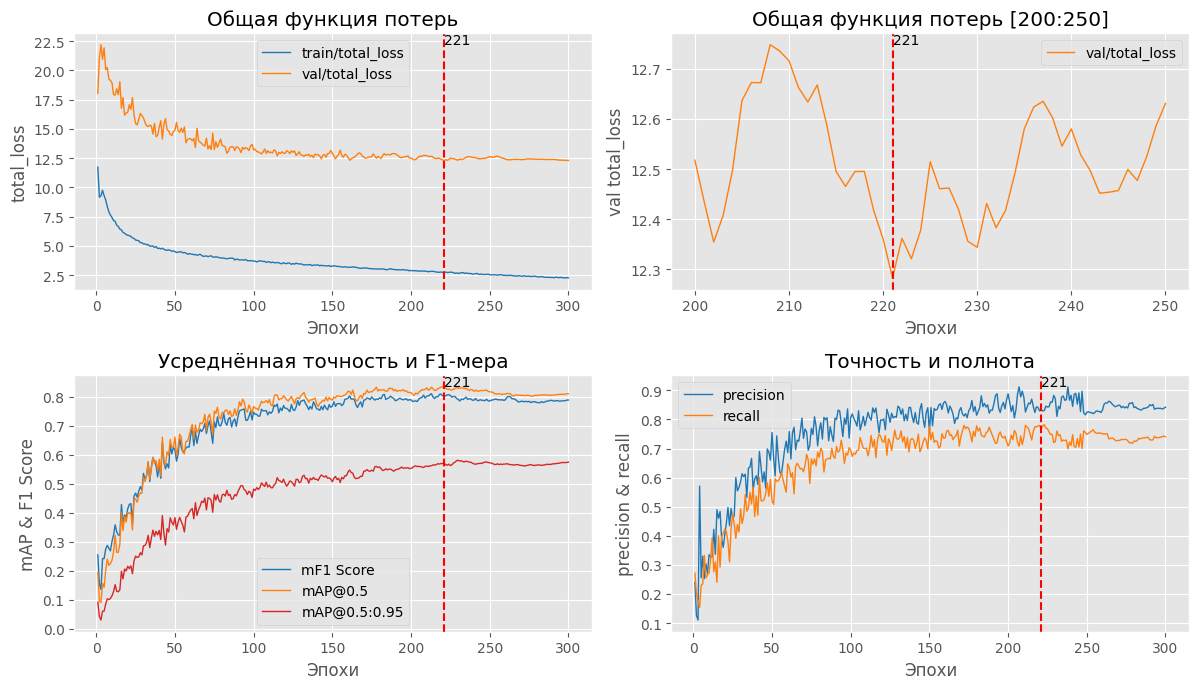

SAVING PLOTS COMPLETE...


In [9]:
# Выбор диапазона эпох от 190 до 250
start_epoch = 200
end_epoch = 250
best_loss = 221

# Получение данных для выбранной модели и диапазона эпох
selected_df = df[(df['                  epoch'] >= \
    start_epoch) & (df['                  epoch'] <= end_epoch)]

# Вывод графиков метрик модели
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 7))

axs[0, 0].plot(df['                  epoch'],
               df['train/total_loss'], color='tab:blue',
               label='train/total_loss', linewidth=1)
axs[0, 0].plot(df['                  epoch'],
               df['val/total_loss'], color='tab:orange',
               label='val/total_loss', linewidth=1)

axs[0, 1].plot(selected_df['                  epoch'],
               selected_df['val/total_loss'],
               color='tab:orange', label='val/total_loss', linewidth=1)

axs[1, 0].plot(df['                  epoch'],
               f1_score_computation(df['   metrics/precision(B)'],
                                    df['      metrics/recall(B)']),
               color='tab:blue', label='mF1 Score', linewidth=1)
axs[1, 0].plot(df['                  epoch'],
               df['       metrics/mAP50(B)'],
               color='tab:orange', label='mAP@0.5', linewidth=1)
axs[1, 0].plot(df['                  epoch'],
               df['    metrics/mAP50-95(B)'],
               color='tab:red', label='mAP@0.5:0.95', linewidth=1)

axs[1, 1].plot(df['                  epoch'],
               df['   metrics/precision(B)'],
               color='tab:blue', label='precision', linewidth=1)
axs[1, 1].plot(df['                  epoch'],
               df['      metrics/recall(B)'],
               color='tab:orange', label='recall', linewidth=1)

axs[0, 0].axvline(x=best_loss, color='red', linestyle='--')
axs[0, 0].text(best_loss, axs[0, 0].get_ylim()[1],
               str(best_loss), color='black', ha='left', va='top')
axs[0, 0].set_xlabel('Эпохи')
axs[0, 0].set_ylabel('total_loss')
axs[0, 0].set_title('Общая функция потерь')
axs[0, 0].legend()

axs_title1 = 'Общая функция потерь [' + str(start_epoch) + ':' + str(end_epoch) + ']'
axs[0, 1].axvline(x=best_loss, color='red', linestyle='--')
axs[0, 1].text(best_loss, axs[0, 1].get_ylim()[1],
               str(best_loss), color='black', ha='left', va='top')
axs[0, 1].set_xlabel('Эпохи')
axs[0, 1].set_ylabel('val total_loss')
axs[0, 1].set_title(axs_title1)
axs[0, 1].legend()

axs[1, 0].axvline(x=best_loss, color='red', linestyle='--')
axs[1, 0].text(best_loss, axs[1, 0].get_ylim()[1],
               str(best_loss), color='black', ha='left', va='top')
axs[1, 0].set_xlabel('Эпохи')
axs[1, 0].set_ylabel('mAP & F1 Score')
axs[1, 0].set_title('Усреднённая точность и F1-мера')
axs[1, 0].legend()

axs[1, 1].axvline(x=best_loss, color='red', linestyle='--')
axs[1, 1].text(best_loss, axs[1, 1].get_ylim()[1],
               str(best_loss), color='black', ha='left', va='top')
axs[1, 1].set_xlabel('Эпохи')
axs[1, 1].set_ylabel('precision & recall')
axs[1, 1].set_title('Точность и полнота')
axs[1, 1].legend()

plt.tight_layout()
plt.savefig(os.path.join(model_path, 'plots.png'))
plt.show()
print('SAVING PLOTS COMPLETE...')

## 2.4 Оценка производительности модели `YOLOv9`

### 2.4.1 Загрузка лучшей обученной модели

In [10]:
model_yolov9_best = YOLO(output_path)
print(MODEL_NAME)
model_yolov9_best.info()  # для вывода информации о модели

yolov9c_d7_e300
YOLOv9c summary: 618 layers, 25531545 parameters, 0 gradients, 103.7 GFLOPs


(618, 25531545, 0, 103.69152)

### 2.4.2 Оценка производительности на тестовой выборке

In [11]:
metrics_yolov9_best = model_yolov9_best.val(  # валидация модели
    data=dataset_path,  # для текущей модели
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    save_json=True,
    plots=True,
    split='test')  # задание выборки для оценки производительности модели

Ultralytics YOLOv8.2.20 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce RTX 2060, 5927MiB)


YOLOv9c summary (fused): 384 layers, 25321561 parameters, 0 gradients, 102.3 GFLOPs


val: Scanning /home/igor/diplom/Crime CCTV Object Detection.v7i.yolov9/test/labels.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.19it/s]


                   all        200        256      0.864      0.795       0.87      0.603
              burglary        200         88      0.907      0.795      0.869      0.661
              fighting        200         76      0.788      0.784      0.863      0.525
               robbery        200         92      0.898      0.804       0.88      0.623
Speed: 0.7ms preprocess, 32.6ms inference, 0.0ms loss, 2.6ms postprocess per image
Saving runs/detect/val66/predictions.json...
Results saved to runs/detect/val66


### 2.4.3 Вывод и сохранение метрик в файл `test_inference.csv`

In [12]:
# directory where all the images are present
test_images = glob.glob(f"{test_images_path}/*.*")
print(f"Количество тестовых изображений: {len(test_images)}")

# Получение информации о модели
model_yolov9_temp = YOLO(output_path)
model_params = model_yolov9_temp.info() 
params_M = round(model_params[1] / 10e5, 1)
flops_B = round(model_params[3], 1)
print('Параметров (млн.):', params_M)
print('FLOPs (млрд.):    ', flops_B)

# Получение времени инференса в миллисекундах
speed_inference = metrics_yolov9_best.speed.get('inference')
avg_fps = round(1 / speed_inference * 1000, 4)   # FPS = 1 / inference_in_seconds
print('Средний FPS:      ', avg_fps)

mf1_score50 = round(metrics_yolov9_best.box.f1.mean(), 4)  # F1
test_map5 = np.round(metrics_yolov9_best.box.map50, 4)  # mAP @0.5
test_map9 = np.round(metrics_yolov9_best.box.map, 4)    # mAP @0.5-0.95
# Список содержит mAP @0.5-0.95 для каждого класса объектов
test_maps = np.round(metrics_yolov9_best.box.maps, 4)
print('mF1 Score:         ', test_map5)
print('mAP@0.5:           ', test_map5)
print('mAP@0.5:0.95:      ', test_map9)
print('mAP@0.5:0.95 по классам:', test_maps)

# Проверяем существование папки и создаём, если её нет
if not os.path.exists(inference_path):
    os.makedirs(inference_path)

# Путь к файлу CSV
test_inference_out = os.path.join(inference_path, 'test_inference.csv')

# Запись данных в файл CSV
with open(test_inference_out, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['model_name', 'images_num', 'mF1_score50', 'mAP50', 'mAP50-95', 'average_fps', 'params_M', 'flops_B'])
    writer.writerow([MODEL_NAME, len(test_images), mf1_score50, test_map5, test_map9, avg_fps, params_M, flops_B])
    print('Файл', test_inference_out, 'записан')

Количество тестовых изображений: 200
YOLOv9c summary: 618 layers, 25531545 parameters, 0 gradients, 103.7 GFLOPs
Параметров (млн.): 25.5
FLOPs (млрд.):     103.7
Средний FPS:       30.6469
mF1 Score:          0.8705
mAP@0.5:            0.8705
mAP@0.5:0.95:       0.6029
mAP@0.5:0.95 по классам: [     0.6606      0.5249       0.623]
Файл /home/igor/diplom/src/runs/detect/yolov9c_d7_e300/inference/test_inference.csv записан


## 2.5 Визуализация предсказания модели `YOLOv9`

### 2.5.1 Визуализация предсказания на тестовых изображениях

In [13]:
test_results = model_yolov9_best(test_path3)  # возвращает лист объектов для результата

# model_yolov9_best.predict(test_path3, augment=True, save=True)

for i, res in enumerate(test_results):  # вывод результатов предсказания
    boxes = res.boxes  # объект Boxes для вывода ограничивающего прямоугольника
    # speed = res.speed  # объект Speed для Словаря скоростей препроцесса
    print(f'Класс {round(boxes.cls[0].item())}: {round(boxes.conf[0].item(), 4)}')
    res.show()  # вывод результатов на экран (в поддерживаемых средах)
    res.save(filename=f'results{i}.jpg')  # сохранение результатов на диск

0: 640x640 1 burglary, 39.3ms
1: 640x640 1 fighting, 39.3ms
2: 640x640 2 robberys, 39.3ms
Speed: 1.9ms preprocess, 39.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
Класс 0: 0.9326
Класс 1: 0.8823
Класс 2: 0.9265



(eog:5418): EOG-CRITICAL **: 15:49:12.684: eog_image_get_file: assertion 'EOG_IS_IMAGE (img)' failed

(eog:5418): GLib-GIO-CRITICAL **: 15:49:12.684: g_file_equal: assertion 'G_IS_FILE (file1)' failed

(eog:5418): EOG-CRITICAL **: 15:49:12.684: eog_image_get_file: assertion 'EOG_IS_IMAGE (img)' failed

(eog:5418): GLib-GIO-CRITICAL **: 15:49:12.684: g_file_equal: assertion 'G_IS_FILE (file1)' failed


### 2.5.2 Визуализация предсказания на видео не из датасета

In [44]:
# Open the video file
# video_path = "https://media.gettyimages.com/id/86383292/video/1970s-montage-two-police-officers-catching-burglar-breaking-into-house-through-window-los.mp4?s=mp4-640x640-gi&k=20&c=EWmrDXHXOFO59YW80VugXDbeV6SX-CSbwFj4G5SQ3H4="
# video_path = "https://media.gettyimages.com/id/99345302/video/montage-two-boys-fighting-in-backyard-bend-oregon-usa.mp4?s=mp4-640x640-gi&k=20&c=J-ztUrNGDgwg1tYU5DOqVhvNp5dcmCxJ5SF-3fVv73A=
# video_file = 'gettyimages-1182-50-640_adpp.mp4'  # fighting
# video_file = 'gettyimages-148367167-640_adpp.mp4'  # robbery
# video_file = 'gettyimages-154791572-640_adpp.mp4'  # burglary !
video_file = 'gettyimages-159818553-640_adpp.mp4'  # robbery, fighting !!
# video_file = 'gettyimages-159822294-640_adpp.mp4'  # burglary
# video_file = 'gettyimages-162882796-640_adpp.mp4'  # burglary !
# video_file = 'gettyimages-2011-120-640_adpp.mp4'  # robbery
# video_file = 'gettyimages-450062442-640_adpp.mp4'  # robbery, fighting
# video_file = 'gettyimages-450065798-640_adpp.mp4'  # robbery, fighting
# video_file = 'gettyimages-652422518-640_adpp.mp4'  # burglary !
#1 video_file = 'gettyimages-86383292-640_adpp.mp4'  # burglary !!
# video_file = 'gettyimages-902-29-640_adpp.mp4'  # robbery
#2 video_file = 'gettyimages-99345302-640_adpp.mp4'  # fighting !!
# video_file = 'gettyimages-ev00075-640_adpp.mp4'  # robbery !
# video_file = 'gettyimages-ev00080-640_adpp.mp4'  # robbery

video_path = os.path.join(current_dir, video_file)
cap = cv2.VideoCapture(video_path)

if (cap.isOpened() == False):
    print('Error while trying to read video. Please check path again')

frame_count = 0  # to count total frames
total_fps = 0    # to get the final frames per second
# Список для хранения словарей с предсказаниями предсказаний
conf_list = []
# Словарь для хранения количества предсказаний в каждом классе
pred_per_class = {}

# Loop through the video frames
while cap.isOpened():
    success, frame = cap.read()  # capture each frame of the video
    
    if success:
        # Run YOLOv9 inference on the frame
        start_time = time.time()  # get the start time
        results = model_yolov9_best(frame)
        end_time = time.time()
        fps = 1 / (end_time - start_time)  # get the current fps
        total_fps += fps  # add `fps` to `total_fps`
        frame_count += 1  # increment frame count
        
        # Visualize the results on the frame
        annotated_frame = results[0].plot()
        boxes = results[0].boxes  # объект Boxes для вывода ограничивающего прямоугольника
        
        cv2.putText(annotated_frame, f"{fps:.1f} FPS",
                    (10, 25),
                    cv2.FONT_HERSHEY_SIMPLEX, 1,
                    (0, 255, 0), 2, lineType=cv2.LINE_AA)
        
        # Display the annotated frame
        cv2.imshow('YOLOv9 Inference', annotated_frame)
        
        # Запись только кадров с предсказаниями
        if boxes.conf.shape[0] > 0:  # Проверка размера тензора
            # Преобразование тензоров в скаляры
            cls = round(boxes.cls[0].item())
            conf = boxes.conf[0].item()
            # Добавление предсказания в список словарей предсказаний
            prediction = {cls: conf}
            conf_list.append(prediction)
            
            # Обновление количества предсказаний для класса cls
            if cls in pred_per_class:
                pred_per_class[cls] += 1
            else:
                pred_per_class[cls] = 1
            
            os.makedirs(os.path.join(inference_path, (os.path.splitext(video_file)[0])), exist_ok=True)
            cv2.imwrite(f"{inference_path}/{os.path.splitext(video_file)[0]}/{frame_count:04d}.jpg", annotated_frame)
        
        # Break the loop if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break
    else:
        # Break the loop if the end of the video is reached
        break

# Release the video capture object and close the display window
cap.release()
cv2.destroyAllWindows() # чтобы окно CV2 не зависало
avg_fps = total_fps / frame_count  # вычисление среднего FPS
print(f'Средний FPS: {avg_fps:.4f}')

if pred_per_class:  # Проверка, что словарь не пустой
    # Вычисление общего числа предсказаний
    pred_total = sum(pred_per_class.values())
    pred_share = pred_total / frame_count
    print(f"Доля кадров с предсказаниями: {(pred_share * 100):.2f}%")
    
    # Вывод процента предсказаний для каждого класса
    for cls, count in pred_per_class.items():
        percentage = (count / pred_total) * 100
        print(f"Класс {cls}: {count} предсказаний, {percentage:.2f}% от общего числа")
else:
    print("Словарь pred_per_class пустой")

# Словарь для хранения средних значений предсказаний для каждого класса
class_avg_conf = {}

# Вычисление среднего значения предсказаний
if conf_list:  # Проверка, что список не пустой
    # Вычисление среднего значения для каждого класса
    for prediction in conf_list:
        for cls_avg, conf_avg in prediction.items():
            if cls_avg in class_avg_conf:
                class_avg_conf[cls_avg].append(conf_avg)
            else:
                class_avg_conf[cls_avg] = [conf_avg]
    
    # Вычисление среднего значения для каждого класса
    for cls_avg, conf_list_avg in class_avg_conf.items():
        avg_conf = np.mean(conf_list_avg)
        class_avg_conf[cls_avg] = avg_conf
        print(f"Класс: {cls_avg}, Среднее значение: {avg_conf:.4f}")
else:
    print("Список conf_list пустой")

# Вычисление общего среднего значения для всех классов
avg_conf_total = np.mean(list(class_avg_conf.values()))
print(f'Среднее значение по всем классам: {avg_conf_total:.4f}')

# Путь к файлу CSV
video_inference_out = os.path.join(inference_path, 'video_inference.csv')

# Проверка, существует ли файл
file_exists = os.path.isfile(video_inference_out)

# Запись данных в файл CSV
with open(video_inference_out, mode='a', newline='') as file:
    writer = csv.writer(file)
    
    # Если файл не существует, создаём заголовок
    if not file_exists:
        writer.writerow(['model_name', 'video_name', 'average_fps',
                         'predictions_total',
                         'predictions0', 'predictions1', 'predictions2',
                         'average_conf_total',
                         'average_conf0', 'average_conf1', 'average_conf2'])
    
    # Создание списка значений для записи в CSV
    values = [MODEL_NAME, video_file, f'{avg_fps:.4f}']
    
    if pred_per_class:
        values.append(f'{pred_share:.4f}')
        values.extend([f'{(pred_per_class.get(cls_pred, 0) / pred_total):.4f}' for cls_pred in range(3)])
    else:
        values.extend([np.nan, np.nan, np.nan, np.nan])
    
    if avg_conf_total:
        values.append(f'{avg_conf_total:.4f}')
        values.extend([f'{class_avg_conf.get(cls_avg, 0):.4f}' for cls_avg in range(3)])
    else:
        values.extend([np.nan, np.nan, np.nan, np.nan])
    
    writer.writerow(values)
    print('Файл', video_inference_out, 'обновлён')



0: 640x640 (no detections), 58.9ms
Speed: 1.7ms preprocess, 58.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 65.6ms
Speed: 2.7ms preprocess, 65.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 57.1ms
Speed: 1.7ms preprocess, 57.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 56.0ms
Speed: 1.8ms preprocess, 56.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 55.8ms
Speed: 1.7ms preprocess, 55.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 45.8ms
Speed: 1.8ms preprocess, 45.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 44.7ms
Speed: 1.7ms preprocess, 44.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 44.7ms
Speed: 1.8ms preprocess, 44.7ms i

### 2.5.3 Визуализация статистики предсказаний видеофайла не из датасета

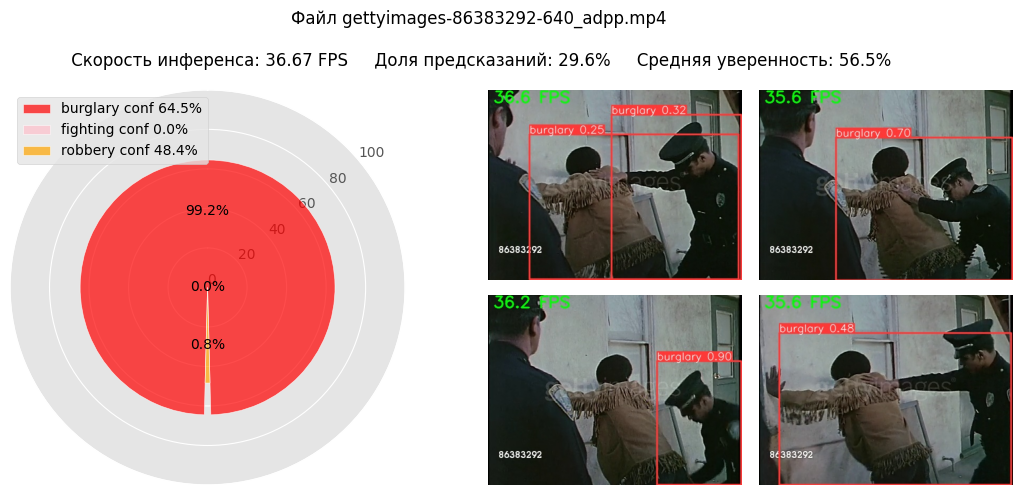

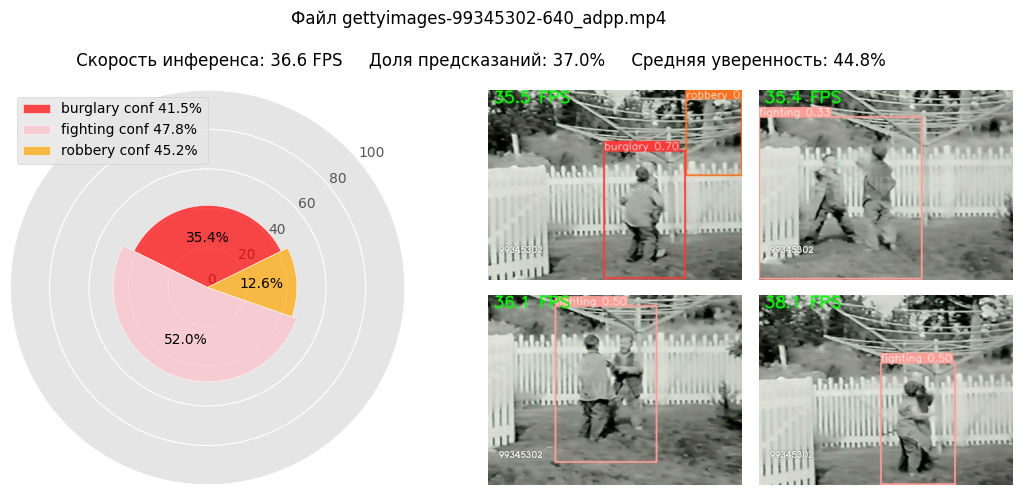

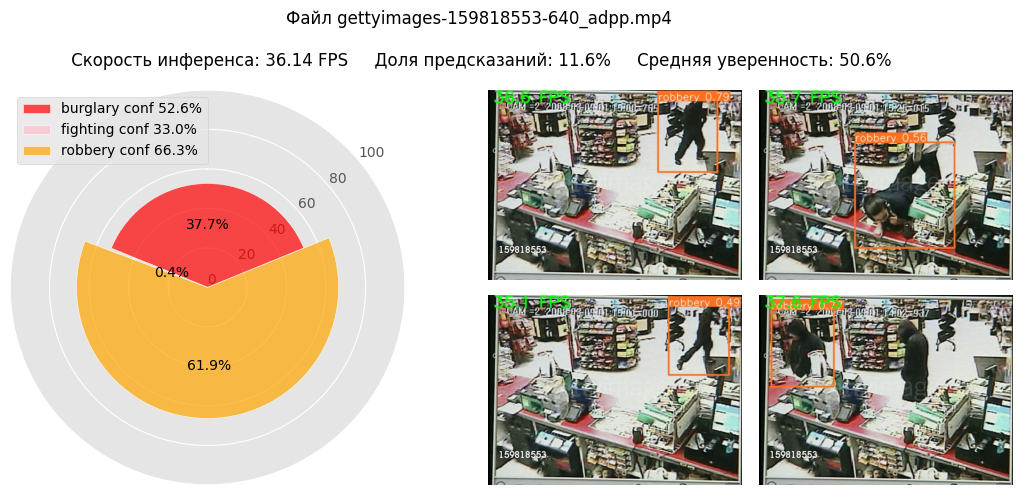

In [14]:
# Задание списков классов и их цветов
labels = ['burglary', 'fighting', 'robbery']
colors = ['red', 'pink', 'orange']
# Инициализвция списков
total_predictions = [0, 0, 0]
total_average_conf = [0, 0, 0]

# Задание пути к файлу CSV
video_inference_out = os.path.join(inference_path, 'video_inference.csv')

# Чтение данных из файла video_inference.csv
with open(video_inference_out, 'r') as file:
    next(file)  # Пропуск заголовка
    for line in file:
        data = line.strip().split(',')
        _, video_name, average_fps, predictions_total, predictions0, predictions1, predictions2, average_conf_total, average_conf0, average_conf1, average_conf2 = data
        
        # Преобразование данных в числовой формат
        average_fps = round(float(average_fps), 2)
        predictions_total = round(float(predictions_total) * 100, 1)
        predictions = [float(predictions0), float(predictions1), float(predictions2)]
        average_conf_total = round(float(average_conf_total) * 100, 1)
        average_conf = [round(float(average_conf0) * 100, 1),
                        round(float(average_conf1) * 100, 1),
                        round(float(average_conf2) * 100, 1)]
        
        # Задание пути к папке с кадрами
        folder_path = os.path.join(inference_path, os.path.splitext(video_name)[0])
        # Пролученик списка файлов в папке с кадрами
        image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
        # Выбор 4 случайных кадров
        random_images = random.sample(image_files, 4)
        
        # Создание графика
        gs = plt.GridSpec(2, 4)
        fig = plt.figure(figsize=(11, 5))
        # Добавление круговой диаграммы
        s1 = fig.add_subplot(gs[:2, :2], polar=True)
        # Инициализвция списков
        predictions_rad = [0, 0, 0]
        predictions_width = [0, 0, 0]
        
        # Вычисление ширины сектора на основе значений predictions
        for i in range(len(predictions)):
            predictions_width[i] = 2*np.pi * predictions[i]
        
        # Задание углов
        predictions_rad[1] = predictions_width[0]/2 + predictions_width[1]/2
        predictions_rad[2] = predictions_width[0]/2 + predictions_width[1] + predictions_width[2]/2
        
        # Построение круговой диаграммы
        bars = s1.bar(x=predictions_rad, height=average_conf, width=predictions_width, bottom=0,
                      linewidth=0.5, edgecolor="white", color=colors, alpha=0.7, label = labels)
        
        # Нанесение надписей
        for bar, pred, angle, height in zip(bars, predictions, predictions_rad, average_conf):
            pred = str(round(pred * 100, 1)) + '%'
            rotation = np.rad2deg(angle)
            s1.text(x=angle, y=bar.get_height() * 0.6, s=pred, ha='center', va='center')
            s1.set_theta_zero_location('N')
            s1.set_rticks(np.arange(0, 101, 20))
            s1.set_rlabel_position(-50)
            s1.set_thetagrids([], labels=[])
            
        new_labels = [f'{label} conf {conf}%' for label, conf in zip(labels, average_conf)]
        s1.legend(new_labels,loc="upper left")
        
        # Добавление изображений предсказаний
        s2 = fig.add_subplot(gs[0, 2])
        img = mpimg.imread(os.path.join(folder_path, random_images[0]))
        s2.imshow(img)
        s2.axis('off')
        s2.grid(False)
        
        s3 = fig.add_subplot(gs[0, 3])
        img = mpimg.imread(os.path.join(folder_path, random_images[1]))
        s3.imshow(img)
        s3.axis('off')
        s3.grid(False)
        
        s4 = fig.add_subplot(gs[1, 2])
        img = mpimg.imread(os.path.join(folder_path, random_images[2]))
        s4.imshow(img)
        s4.axis('off')
        s4.grid(False)
        
        s5 = fig.add_subplot(gs[1, 3])
        img = mpimg.imread(os.path.join(folder_path, random_images[3]))
        s5.imshow(img)
        s5.axis('off')
        s5.grid(False)
        
        plt.suptitle(f'Файл {video_name}\n\n Скорость инференса: {average_fps} FPS     Доля предсказаний: {predictions_total}%     Средняя уверенность: {average_conf_total}%')
        plt.tight_layout()
        plt.savefig(os.path.join(inference_path, f'{video_name}.png'))
        plt.show()

## 2.6 Экспорт модели `YOLOv9` и очистка видеокэша `PyTorch`

### 2.6.1 Экспорт лучшей модели `YOLOv9` в файл формата `ONNX`

In [37]:
model_yolov9_best.export(format='onnx')

Ultralytics YOLOv8.2.20 🚀 Python-3.10.12 torch-2.3.0+cu121 CPU (Intel Core(TM) i7-9750H 2.60GHz)
rt-detr-l summary: 498 layers, 31989905 parameters, 0 gradients, 103.4 GFLOPs

PyTorch: starting from '/home/igor/diplom/src/runs/detect/rtdetrl_d7_e300/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 300, 7) (63.1 MB)

ONNX: starting export with onnx 1.16.0 opset 17...
ONNX: export success ✅ 10.2s, saved as '/home/igor/diplom/src/runs/detect/rtdetrl_d7_e300/weights/best.onnx' (122.5 MB)

Export complete (13.4s)
Results saved to /home/igor/diplom/src/runs/detect/rtdetrl_d7_e300/weights
Predict:         yolo predict task=detect model=/home/igor/diplom/src/runs/detect/rtdetrl_d7_e300/weights/best.onnx imgsz=640  
Validate:        yolo val task=detect model=/home/igor/diplom/src/runs/detect/rtdetrl_d7_e300/weights/best.onnx imgsz=640 data=/home/igor/diplom/Crime CCTV Object Detection.v7i.yolov9/data.yaml  
Visualize:       https://netron.app


'/home/igor/diplom/src/runs/detect/rtdetrl_d7_e300/weights/best.onnx'

### 2.6.2 Очистка видеокэша `PyTorch`

In [15]:
torch.cuda.empty_cache()

# 3. Модели `PyTorch`

## 3.1 Константы, пути, классы, функции моделей `PyTorch`

### 3.1.1 Константы моделей `PyTorch`

In [7]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
BATCH = 4        # зависит от видеопамяти GPU
RESIZE_TO = 640  # resize the image for training and transforms
NUM_EPOCHS = 50
# Number of parallel workers for data loading
NUM_WORKERS = 0  # опытным путём, но в целом num_workers = 4 * num_GPUs
# индекс 0 зарезервирован для background
CLASSES = ['__background__', 'burglary', 'fighting', 'robbery']
NUM_CLASSES = len(CLASSES)
COLORS = np.array([   # цвета разных классов
    [255, 255, 255],  # white для '__background__'
    [0, 0, 255],      # red для 'burglary'
    [203, 192, 255],  # pink для 'fighting'
    [0, 165, 255]     # orange для 'robbery'
])
VISUALIZE_TRANSFORMED_IMAGES = False  # нужно ли визуализировать после создания data loaders
MODEL = 'fasterrcnn_resnet50_d8_e50'  # имя для хранения обученной модели

### 3.1.2 Пути к папкам и файлам

In [8]:
# Получаем путь к текущей папке /src
# current_dir = os.path.dirname(os.path.abspath(__file__))  # для .py
current_dir = os.getcwd()  # для .ipynb

# Находим папку проекта относительно папки /src
project_path = os.path.abspath(os.path.join(current_dir, os.pardir))
print(f"Путь к папке проекта {project_path}")

# Задаём путь к датасету
data_folder = os.path.join(project_path, 'Crime CCTV Object Detection.v8i.yolov9')
# Папки с изображениями и TXT файлами разметки
TRAIN_DIR = os.path.join(data_folder, 'train')
VALID_DIR = os.path.join(data_folder, 'valid')
TEST_DIR  = os.path.join(data_folder, 'test')
print(f"Путь к датасету {data_folder}")

# Папки и файлы для сохранения результатов
OUT_DIR = os.path.join(current_dir, 'outputs', MODEL)
INFERENCE_DIR = os.path.join(OUT_DIR, 'inference')
image_inference_out = os.path.join(INFERENCE_DIR, 'test_inference.csv')
video_inference_out = os.path.join(INFERENCE_DIR, 'video_inference.csv')

print(f"Путь к файлу модели и графикам {OUT_DIR}")

# Проверяем существование папки и создаём, если её нет
if not os.path.exists(OUT_DIR):
    os.makedirs(OUT_DIR)
if not os.path.exists(INFERENCE_DIR):
    os.makedirs(INFERENCE_DIR)

best_model_path = os.path.join(OUT_DIR, 'best_model.pth')

# Список  моделей PyTorch
models_pt = [
    MODEL,  # текущая модель
    # 'fasterrcnn_resnet50_d8_e50',
    # 'fasterrcnn_resnet50_d8_e25',     # плохо
    # 'fasterrcnn_mobilenet_d8_e100',  # плохо
    'fasterrcnn_mobilenet_d8_e18',
    # 'ssd300_vgg16_d8_e50a',          # плохо
    # 'ssd300_vgg16_d8_e30',           # плохо
    'ssd300_vgg16_d8_e15'
]

# Создание путей к файлам результатов для каждой модели
results_file_pt = 'test_inference.csv'
results_path_pt = {key: os.path.join(current_dir, 'outputs', key, 'inference', results_file_pt) for key in models_pt}
print(f"Путь к файлу результатов {results_path_pt[MODEL]}")

Путь к папке проекта c:\ML\Диплом
Путь к датасету c:\ML\Диплом\Crime CCTV Object Detection.v8i.yolov9
Путь к файлу модели и графикам c:\ML\Диплом\src\outputs\fasterrcnn_resnet50_d8_e50
Путь к файлу результатов c:\ML\Диплом\src\outputs\fasterrcnn_resnet50_d8_e50\inference\test_inference.csv


### 3.1.3 Классы

In [71]:
# Отслеживание функции потерь на тренировочной и валидационной выборках,
# а также получение среднего значения потерь для каждой эпохи
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0
    
    def send(self, value):
        self.current_total += value
        self.iterations += 1
    
    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations
    
    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0


# Сохранение лучшей модели
class SaveBestModelLoss:
    '''
    Class to save the best model while training. If the current epoch's 
    validation loss is less than the previous least less, then save the
    model state.
    '''
    def __init__(self, best_valid_loss=float('inf')):
        self.best_valid_loss = best_valid_loss
    
    def __call__(self,
                 current_valid_loss,
                 epoch, model,
                 optimizer):
        global best_model_path
        
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBEST VALIDATION LOSS: {self.best_valid_loss}")
            print(f"\nSAVING BEST MODEL FOR EPOCH: {epoch+1}\n")
            torch.save({'epoch': epoch+1,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict()},
                       best_model_path)

class SaveBestModelmAP:
    '''
    Class to save the best model while training. If the current epoch's 
    validation mAP@0.5:0.95 IoU higher than the previous highest,
    then save the model state.
    '''
    def __init__(self, best_valid_map=float(0)):
        self.best_valid_map = best_valid_map
    
    def __call__(self, model,
                 current_valid_map,
                 epoch,
                 OUT_DIR):
        global best_model_path
        
        if current_valid_map > self.best_valid_map:
            self.best_valid_map = current_valid_map
            print(f"\nBEST VALIDATION mAP: {self.best_valid_map}")
            print(f"\nSAVING BEST MODEL FOR EPOCH: {epoch+1}\n")
            torch.save({'epoch': epoch+1,
                        'model_state_dict': model.state_dict()},
                       best_model_path)

# Работа с произвольным набором данных
class CustomDataset(Dataset):
    def __init__(self, dir_path, width, height, classes, transforms=None):
        self.transforms = transforms
        self.dir_path = dir_path
        self.height = height
        self.width = width
        self.classes = classes
        
        # get all the image paths in sorted order
        self.image_paths = glob.glob(os.path.join(self.dir_path, 'images', '*.jpg'))
        self.all_images = [image_path.split(os.path.sep)[-1] for image_path in self.image_paths]
        self.all_images = sorted(self.all_images)
    
    def __len__(self):
        return len(self.all_images)
    
    def __getitem__(self, idx):
        # capture the image name and the full image path
        image_name = self.all_images[idx]
        image_path = os.path.join(self.dir_path, 'images', image_name)
        # Read and preprocess the image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image_resized = cv2.resize(image, (self.width, self.height))
        image_resized /= 255.0
        
        # capture the corresponding TXT file for getting the annotations
        annot_filename = image_name[:-4] + '.txt'
        annot_file_path = os.path.join(self.dir_path, 'labels', annot_filename)
        boxes, labels = [], []
         # get the height and width of the image
        image_width = image.shape[1]
        image_height = image.shape[0]
        
        # box coordinates for txt files are extracted and corrected for image size given
        with open(annot_file_path, 'r') as file:
            lines = file.readlines()
            
            for line in lines:
                data = line.strip().split()
                
                if len(data) == 5:  # Проверяем, что строка содержит 5 элементов
                    class_label = int(data[0]) + 1  # индекс класса объекта
                    # map the current object name to `classes` list
                    labels.append(class_label)
                    x_center = float(data[1])    # X-координата центра объекта
                    y_center = float(data[2])    # Y-координата центра объекта
                    box_width = float(data[3])   # Ширина объекта
                    box_height = float(data[4])  # Высота объекта
                    # Преобразование центра объекта и его размеров в координаты углов прямоугольника
                    xmin = int((x_center - box_width / 2) * image_width)    # Xmin
                    ymin = int((y_center - box_height / 2) * image_height)  # Ymin
                    xmax = int((x_center + box_width / 2) * image_width)    # Xmax
                    ymax = int((y_center + box_height / 2) * image_height)  # Ymax
                    # resize the bounding boxes according to the desired `width`, `height`
                    xmin_final = (xmin / image_width) * self.width
                    ymin_final = (ymin / image_height) * self.height
                    xmax_final = (xmax / image_width) * self.width
                    yamx_final = (ymax / image_height) * self.height
                    boxes.append([xmin_final, ymin_final, xmax_final, yamx_final])
        
        # bounding box to tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # area of the bounding boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) if len(boxes) > 0 \
            else torch.as_tensor(boxes, dtype=torch.float32)
        # no crowd instances
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        # labels to tensor
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        # prepare the final `target` dictionary
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        image_id = torch.tensor([idx])
        target["image_id"] = image_id
        
        # apply the image transforms
        if self.transforms:
            sample = self.transforms(image = image_resized,
                                     bboxes = target['boxes'],
                                     labels = labels)
            image_resized = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
        
        if np.isnan((target['boxes']).numpy()).any() or target['boxes'].shape == torch.Size([0]):
            target['boxes'] = torch.zeros((0, 4), dtype=torch.int64)
        
        return image_resized, target

### 3.1.4 Функции

In [72]:
def collate_fn(batch):
    '''
    Function to handle the data loading as different images may have
    differentnumber of objects and to handle varying size tensors as well.
    '''
    return tuple(zip(*batch))

# Function to define the tranforms
def get_train_transform():
    return A.Compose([A.Resize(RESIZE_TO, RESIZE_TO, p=1),
                      A.Normalize(p=1),
                      ToTensorV2(p=1.0)],
                     p=1.0,
                     bbox_params={'format': 'pascal_voc',
                                  'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([ToTensorV2(p=1.0)],
                     bbox_params={'format': 'pascal_voc',
                                  'label_fields': ['labels']})

def show_tranformed_image(train_loader):
    '''
    This function shows the transformed images from the `train_loader`.
    Helps to check whether the tranformed images along
    with the corresponding labels are correct or not.
    Only runs if `VISUALIZE_TRANSFORMED_IMAGES = True` in CONST section.
    '''
    if len(train_loader) > 0:
        for i in range(1):
            images, targets = next(iter(train_loader))
            images = list(image.to(DEVICE) for image in images)
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
            boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
            labels = targets[i]['labels'].cpu().numpy().astype(np.int32)
            sample = images[i].permute(1, 2, 0).cpu().numpy()
            sample = cv2.cvtColor(sample, cv2.COLOR_RGB2BGR)
            
            for box_num, box in enumerate(boxes):
                cv2.rectangle(sample,
                              (box[0], box[1]),
                              (box[2], box[3]),
                              (0, 0, 255), 2)
                cv2.putText(sample,
                            CLASSES[labels[box_num]],
                            (box[0], box[1]-10),
                            cv2.FONT_HERSHEY_SIMPLEX,
                            1.0, (0, 0, 255), 2)
            
            cv2.imshow('Transformed image', sample)
            cv2.waitKey(0)
            cv2.destroyAllWindows()  # чтобы окно CV2 не зависало

# Function to visualize a single sample
def visualize_sample(image, target):
    for box_num in range(len(target['boxes'])):
        box = target['boxes'][box_num]
        label = CLASSES[target['labels'][box_num]]
        cv2.rectangle(image, 
                      (int(box[0]), int(box[1])),
                      (int(box[2]), int(box[3])),
                      (0, 255, 0), 2)
        cv2.putText(image, label,
                    (int(box[0]), int(box[1]-5)),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.7, (0, 0, 255), 2)
    
    cv2.imshow('Image', image)
    cv2.waitKey(1)
    cv2.destroyAllWindows()  # чтобы окно CV2 не зависало

# Модель `PyTorch` с предварительно обученными весами на датасете `COCO`
def create_model(num_classes, model_name):
    # Load the PyTorch pretrained model
    if 'resnet50' in model_name:
        model = fasterrcnn_resnet50_fpn(
            weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1,
            pretrained=True
        )
    elif 'mobilenet' in model_name:
        model = fasterrcnn_mobilenet_v3_large_fpn(
            weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.COCO_V1,
            pretrained=True
        )
    
    # get the number of input features 
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # define a new head for the detector with required number of classes
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model

# Модель `SSD` с предварительно обученными весами на датасете `COCO`
def create_model_ssd(num_classes, size):
    # Load the Torchvision pretrained model
    model = ssd300_vgg16(
        weights=SSD300_VGG16_Weights.COCO_V1,
        pretrained=True
    )
    # Retrieve the list of input channels
    in_channels = _utils.retrieve_out_channels(model.backbone, (size, size))
    # List containing number of anchors based on aspect ratios
    num_anchors = model.anchor_generator.num_anchors_per_location()
    # The classification head
    model.head.classification_head = SSDClassificationHead(
        in_channels=in_channels,
        num_anchors=num_anchors,
        num_classes=num_classes
    )
    # Image size for transforms
    model.transform.min_size = (size,)
    model.transform.max_size = size
    
    return model

# Function for running training iterations
def train(train_data_loader, model):
    print('Training')
    model.train()
    global optimizer
    global train_itr
    global train_loss_list
    global train_loss_hist
    
    # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))
    
    for _, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets = data
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)  # Return the loss
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        train_loss_list.append(loss_value)
        train_loss_hist.send(loss_value)  # Average out the loss
        losses.backward()
        optimizer.step()
        train_itr += 1
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    
    return train_loss_list

# Function for running validation iterations
def validate(valid_data_loader, model):
    print('Validating')
    global val_itr
    global val_loss_list
    global val_loss_hist
    
    # initialize tqdm progress bar
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))
    
    for _, data in enumerate(prog_bar):
        images, targets = data
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        
        with torch.no_grad():
            loss_dict = model(images, targets)  # Return the loss
        
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        val_loss_list.append(loss_value)
        val_loss_hist.send(loss_value)  # Average out the loss
        val_itr += 1
        
        #update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    
    return val_loss_list

# Функция для сохранения результатов обучения
def save_training_results(OUT_DIR, epoch, train_loss, val_loss):
    res_file = os.path.join(OUT_DIR, 'results.csv')
    
    # Проверяем, началось ли новое обучение
    if epoch == 0:
        # Если это начало нового обучения, обнуляем файл результатов
        with open(res_file, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['epoch', 'train_loss', 'val_loss'])
    
    # Записываем данные в файл
    with open(res_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([epoch+1, train_loss, val_loss])
    
    print(f'Данные обучения эпохи {epoch+1} сохранены в {res_file}')

# Function to save the trained model till current epoch, or whenever called
def save_model(epoch, model, optimizer):
    torch.save({'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()},
               os.path.join(OUT_DIR, 'last_model.pth'))

def convert_yolo_coordinates_to_voc(x_c_n,
                                    y_c_n,
                                    width_n,
                                    height_n,
                                    img_width,
                                    img_height):
    # remove normalization given the size of the image
    x_c = float(x_c_n) * img_width
    y_c = float(y_c_n) * img_height
    width = float(width_n) * img_width
    height = float(height_n) * img_height
    # compute half width and half height
    half_width = width / 2
    half_height = height / 2
    # compute left, top, right, bottom
    left = int(x_c - half_width)
    top = int(y_c - half_height)
    right = int(x_c + half_width)
    bottom = int(y_c + half_height)
    
    return left, top, right, bottom

## 3.2 Проверка работоспособности и загрузка датасета

### 3.2.1 Проверка работоспособности конвейера `CustomDataset` с демонстрацией образцов

In [73]:
# sanity check of the Dataset pipeline with sample visualization
dataset = CustomDataset(TRAIN_DIR, RESIZE_TO, RESIZE_TO, CLASSES)
print(f"Количество тренировочных изображений: {len(dataset)}")
NUM_SAMPLES_TO_VISUALIZE = 3

for i in range(NUM_SAMPLES_TO_VISUALIZE):
    image, target = dataset[i]
    visualize_sample(image, target)

Количество тренировочных изображений: 2913


### 3.2.2 Загрузка датасета

In [74]:
train_dataset = CustomDataset(TRAIN_DIR,
                              RESIZE_TO,
                              RESIZE_TO,
                              CLASSES,
                              get_train_transform())
valid_dataset = CustomDataset(VALID_DIR,
                              RESIZE_TO,
                              RESIZE_TO,
                              CLASSES,
                              get_valid_transform())
train_loader = DataLoader(train_dataset,
                          batch_size=BATCH,
                          shuffle=True,
                          num_workers=NUM_WORKERS,
                          collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset,
                          batch_size=BATCH,
                          shuffle=False,
                          num_workers=NUM_WORKERS,
                          collate_fn=collate_fn)
print(f"Количество тренировочных изображений: {len(train_dataset)}")
print(f"Количество валидационных изображений: {len(valid_dataset)}\n")

Количество тренировочных изображений: 2913
Количество валидационных изображений: 400



## 3.3 Загрузка и обучение моделей `Faster R-CNN`

### 3.3.1 Загрузка и подготовка модели `Faster R-CNN` с предварительно обученными весами на датасете `COCO`

In [203]:
# Инициализация модели и передача её вычислительному устройству
model = create_model(num_classes=NUM_CLASSES, model_name=MODEL)
model = model.to(DEVICE)

# Получение параметров модели
params = [p for p in model.parameters() if p.requires_grad]

# Определение оптимизатора
# optimizer = torch.optim.AdamW(params, lr=0.0001, weight_decay=0.0005)
optimizer = torch.optim.SGD(params, lr=0.0001, momentum=0.9, weight_decay=0.0005)

# Инициализация класса Averager
train_loss_hist = Averager()
val_loss_hist = Averager()
train_itr = 1
val_itr = 1

# Списки для хранения значений функции потерь обучения и валидации
# для всех итераций до ena и построения графиков для всех итераций
train_loss_list = []
val_loss_list = []

# Показывать или нет преобразованные изображения из загрузчика данных
if VISUALIZE_TRANSFORMED_IMAGES:
    show_tranformed_image(train_loader)

# Инициализация класса SaveBestModelLoss
save_best_model = SaveBestModelLoss()

### 3.3.2 Обучение модели `Faster R-CNN`

In [204]:
for epoch in range(NUM_EPOCHS):
    print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")
    
    # Сброс истории потерь обучения и валидации для текущей эпохи
    train_loss_hist.reset()
    val_loss_hist.reset()
    
    # Запуск таймера и проведение обучения и валидации
    start = time.time()
    train_loss = train(train_loader, model)
    val_loss = validate(valid_loader, model)
    train_loss_epoch = round(train_loss_hist.value, 4)
    val_loss_epoch = round(val_loss_hist.value, 4)
    print(f"Epoch #{epoch+1} train loss: {train_loss_epoch}")
    print(f"Epoch #{epoch+1} valid loss: {val_loss_epoch}")
    end = time.time()
    print(f"Took {((end - start) / 60):.2f} minutes for epoch {epoch+1}")
    
    # Сохранение лучшей модели, пока будет наименьшее значение потерь в текущей эпохе
    save_best_model(val_loss_hist.value, epoch, model, optimizer)
    save_model(epoch, model, optimizer)  # сохранение текущей эпохи модели
    # Сохранение результатов обучения текущей эпохи в файл результатов
    save_training_results(OUT_DIR, epoch, train_loss_epoch, val_loss_epoch)
    
    time.sleep(1)  # засыпать на 1 секунду после каждой эпохи


EPOCH 1 of 25
Training


Loss: 0.9274: 100%|██████████| 729/729 [01:54<00:00,  6.34it/s]


Validating


Loss: 1.1976: 100%|██████████| 100/100 [00:10<00:00,  9.60it/s]


Epoch #1 train loss: 0.7568
Epoch #1 valid loss: 1.111
Took 2.09 minutes for epoch 1

BEST VALIDATION LOSS: 1.1110396528244018

SAVING BEST MODEL FOR EPOCH: 1

Данные обучения эпохи 1 сохранены в /home/igor/diplom/src/outputs/fasterrcnn_mobilenet_d8_e25/results.csv

EPOCH 2 of 25
Training


Loss: 0.1959: 100%|██████████| 729/729 [01:55<00:00,  6.29it/s]


Validating


Loss: 1.1863: 100%|██████████| 100/100 [00:10<00:00,  9.75it/s]


Epoch #2 train loss: 0.7299
Epoch #2 valid loss: 1.0805
Took 2.10 minutes for epoch 2

BEST VALIDATION LOSS: 1.080531523823738

SAVING BEST MODEL FOR EPOCH: 2

Данные обучения эпохи 2 сохранены в /home/igor/diplom/src/outputs/fasterrcnn_mobilenet_d8_e25/results.csv

EPOCH 3 of 25
Training


Loss: 1.4910: 100%|██████████| 729/729 [01:55<00:00,  6.29it/s]


Validating


Loss: 1.1663: 100%|██████████| 100/100 [00:10<00:00,  9.65it/s]


Epoch #3 train loss: 0.7244
Epoch #3 valid loss: 1.0923
Took 2.10 minutes for epoch 3
Данные обучения эпохи 3 сохранены в /home/igor/diplom/src/outputs/fasterrcnn_mobilenet_d8_e25/results.csv

EPOCH 4 of 25
Training


Loss: 0.4906: 100%|██████████| 729/729 [01:55<00:00,  6.30it/s]


Validating


Loss: 1.1945: 100%|██████████| 100/100 [00:10<00:00,  9.77it/s]


Epoch #4 train loss: 0.7262
Epoch #4 valid loss: 1.0979
Took 2.10 minutes for epoch 4
Данные обучения эпохи 4 сохранены в /home/igor/diplom/src/outputs/fasterrcnn_mobilenet_d8_e25/results.csv

EPOCH 5 of 25
Training


Loss: 0.8381: 100%|██████████| 729/729 [01:56<00:00,  6.28it/s]


Validating


Loss: 1.1674: 100%|██████████| 100/100 [00:10<00:00,  9.72it/s]


Epoch #5 train loss: 0.7231
Epoch #5 valid loss: 1.096
Took 2.11 minutes for epoch 5
Данные обучения эпохи 5 сохранены в /home/igor/diplom/src/outputs/fasterrcnn_mobilenet_d8_e25/results.csv

EPOCH 6 of 25
Training


Loss: 0.3452: 100%|██████████| 729/729 [01:56<00:00,  6.27it/s]


Validating


Loss: 1.1692: 100%|██████████| 100/100 [00:10<00:00,  9.64it/s]


Epoch #6 train loss: 0.7268
Epoch #6 valid loss: 1.0893
Took 2.11 minutes for epoch 6
Данные обучения эпохи 6 сохранены в /home/igor/diplom/src/outputs/fasterrcnn_mobilenet_d8_e25/results.csv

EPOCH 7 of 25
Training


Loss: 0.4615: 100%|██████████| 729/729 [01:56<00:00,  6.26it/s]


Validating


Loss: 1.1750: 100%|██████████| 100/100 [00:10<00:00,  9.72it/s]


Epoch #7 train loss: 0.728
Epoch #7 valid loss: 1.0931
Took 2.11 minutes for epoch 7
Данные обучения эпохи 7 сохранены в /home/igor/diplom/src/outputs/fasterrcnn_mobilenet_d8_e25/results.csv

EPOCH 8 of 25
Training


Loss: 0.7947: 100%|██████████| 729/729 [01:56<00:00,  6.27it/s]


Validating


Loss: 1.1938: 100%|██████████| 100/100 [00:10<00:00,  9.82it/s]


Epoch #8 train loss: 0.7256
Epoch #8 valid loss: 1.0991
Took 2.11 minutes for epoch 8
Данные обучения эпохи 8 сохранены в /home/igor/diplom/src/outputs/fasterrcnn_mobilenet_d8_e25/results.csv

EPOCH 9 of 25
Training


Loss: 0.7026: 100%|██████████| 729/729 [01:56<00:00,  6.25it/s]


Validating


Loss: 1.2021: 100%|██████████| 100/100 [00:10<00:00,  9.70it/s]


Epoch #9 train loss: 0.7294
Epoch #9 valid loss: 1.0962
Took 2.12 minutes for epoch 9
Данные обучения эпохи 9 сохранены в /home/igor/diplom/src/outputs/fasterrcnn_mobilenet_d8_e25/results.csv

EPOCH 10 of 25
Training


Loss: 1.6396: 100%|██████████| 729/729 [01:56<00:00,  6.24it/s]


Validating


Loss: 1.1941: 100%|██████████| 100/100 [00:10<00:00,  9.68it/s]


Epoch #10 train loss: 0.7328
Epoch #10 valid loss: 1.0938
Took 2.12 minutes for epoch 10
Данные обучения эпохи 10 сохранены в /home/igor/diplom/src/outputs/fasterrcnn_mobilenet_d8_e25/results.csv

EPOCH 11 of 25
Training


Loss: 0.7822: 100%|██████████| 729/729 [01:56<00:00,  6.24it/s]


Validating


Loss: 1.1707: 100%|██████████| 100/100 [00:10<00:00,  9.68it/s]


Epoch #11 train loss: 0.7304
Epoch #11 valid loss: 1.084
Took 2.12 minutes for epoch 11
Данные обучения эпохи 11 сохранены в /home/igor/diplom/src/outputs/fasterrcnn_mobilenet_d8_e25/results.csv

EPOCH 12 of 25
Training


Loss: 0.3380: 100%|██████████| 729/729 [01:56<00:00,  6.25it/s]


Validating


Loss: 1.1832: 100%|██████████| 100/100 [00:10<00:00,  9.65it/s]


Epoch #12 train loss: 0.7336
Epoch #12 valid loss: 1.0853
Took 2.12 minutes for epoch 12
Данные обучения эпохи 12 сохранены в /home/igor/diplom/src/outputs/fasterrcnn_mobilenet_d8_e25/results.csv

EPOCH 13 of 25
Training


Loss: 0.6130: 100%|██████████| 729/729 [01:56<00:00,  6.24it/s]


Validating


Loss: 1.1992: 100%|██████████| 100/100 [00:10<00:00,  9.67it/s]


Epoch #13 train loss: 0.7349
Epoch #13 valid loss: 1.084
Took 2.12 minutes for epoch 13
Данные обучения эпохи 13 сохранены в /home/igor/diplom/src/outputs/fasterrcnn_mobilenet_d8_e25/results.csv

EPOCH 14 of 25
Training


Loss: 0.9301: 100%|██████████| 729/729 [01:56<00:00,  6.25it/s]


Validating


Loss: 1.1864: 100%|██████████| 100/100 [00:10<00:00,  9.65it/s]


Epoch #14 train loss: 0.7318
Epoch #14 valid loss: 1.076
Took 2.12 minutes for epoch 14

BEST VALIDATION LOSS: 1.076047767996788

SAVING BEST MODEL FOR EPOCH: 14

Данные обучения эпохи 14 сохранены в /home/igor/diplom/src/outputs/fasterrcnn_mobilenet_d8_e25/results.csv

EPOCH 15 of 25
Training


Loss: 0.6025: 100%|██████████| 729/729 [01:56<00:00,  6.25it/s]


Validating


Loss: 1.1918: 100%|██████████| 100/100 [00:10<00:00,  9.72it/s]


Epoch #15 train loss: 0.7356
Epoch #15 valid loss: 1.0741
Took 2.11 minutes for epoch 15

BEST VALIDATION LOSS: 1.0740660744905473

SAVING BEST MODEL FOR EPOCH: 15

Данные обучения эпохи 15 сохранены в /home/igor/diplom/src/outputs/fasterrcnn_mobilenet_d8_e25/results.csv

EPOCH 16 of 25
Training


Loss: 1.3237: 100%|██████████| 729/729 [01:56<00:00,  6.27it/s]


Validating


Loss: 1.2058: 100%|██████████| 100/100 [00:10<00:00,  9.63it/s]


Epoch #16 train loss: 0.7331
Epoch #16 valid loss: 1.0779
Took 2.11 minutes for epoch 16
Данные обучения эпохи 16 сохранены в /home/igor/diplom/src/outputs/fasterrcnn_mobilenet_d8_e25/results.csv

EPOCH 17 of 25
Training


Loss: 0.7682: 100%|██████████| 729/729 [01:56<00:00,  6.25it/s]


Validating


Loss: 1.1862: 100%|██████████| 100/100 [00:10<00:00,  9.80it/s]


Epoch #17 train loss: 0.7349
Epoch #17 valid loss: 1.0666
Took 2.11 minutes for epoch 17

BEST VALIDATION LOSS: 1.0665561252832412

SAVING BEST MODEL FOR EPOCH: 17

Данные обучения эпохи 17 сохранены в /home/igor/diplom/src/outputs/fasterrcnn_mobilenet_d8_e25/results.csv

EPOCH 18 of 25
Training


Loss: 0.7051: 100%|██████████| 729/729 [01:56<00:00,  6.26it/s]


Validating


Loss: 1.1807: 100%|██████████| 100/100 [00:10<00:00,  9.70it/s]


Epoch #18 train loss: 0.7367
Epoch #18 valid loss: 1.0644
Took 2.11 minutes for epoch 18

BEST VALIDATION LOSS: 1.0643791490793229

SAVING BEST MODEL FOR EPOCH: 18

Данные обучения эпохи 18 сохранены в /home/igor/diplom/src/outputs/fasterrcnn_mobilenet_d8_e25/results.csv

EPOCH 19 of 25
Training


Loss: 0.7970: 100%|██████████| 729/729 [01:56<00:00,  6.25it/s]


Validating


Loss: 1.1669: 100%|██████████| 100/100 [00:10<00:00,  9.76it/s]


Epoch #19 train loss: 0.732
Epoch #19 valid loss: 1.0651
Took 2.11 minutes for epoch 19
Данные обучения эпохи 19 сохранены в /home/igor/diplom/src/outputs/fasterrcnn_mobilenet_d8_e25/results.csv

EPOCH 20 of 25
Training


Loss: 0.8237: 100%|██████████| 729/729 [01:56<00:00,  6.24it/s]


Validating


Loss: 1.1732: 100%|██████████| 100/100 [00:10<00:00,  9.62it/s]


Epoch #20 train loss: 0.7347
Epoch #20 valid loss: 1.0585
Took 2.12 minutes for epoch 20

BEST VALIDATION LOSS: 1.058488009572029

SAVING BEST MODEL FOR EPOCH: 20

Данные обучения эпохи 20 сохранены в /home/igor/diplom/src/outputs/fasterrcnn_mobilenet_d8_e25/results.csv

EPOCH 21 of 25
Training


Loss: 0.5437: 100%|██████████| 729/729 [01:56<00:00,  6.24it/s]


Validating


Loss: 1.1822: 100%|██████████| 100/100 [00:10<00:00,  9.77it/s]


Epoch #21 train loss: 0.7372
Epoch #21 valid loss: 1.0602
Took 2.12 minutes for epoch 21
Данные обучения эпохи 21 сохранены в /home/igor/diplom/src/outputs/fasterrcnn_mobilenet_d8_e25/results.csv

EPOCH 22 of 25
Training


Loss: 1.3551: 100%|██████████| 729/729 [01:56<00:00,  6.24it/s]


Validating


Loss: 1.1614: 100%|██████████| 100/100 [00:10<00:00,  9.68it/s]


Epoch #22 train loss: 0.7325
Epoch #22 valid loss: 1.0573
Took 2.12 minutes for epoch 22

BEST VALIDATION LOSS: 1.0573143446445465

SAVING BEST MODEL FOR EPOCH: 22

Данные обучения эпохи 22 сохранены в /home/igor/diplom/src/outputs/fasterrcnn_mobilenet_d8_e25/results.csv

EPOCH 23 of 25
Training


Loss: 0.8565: 100%|██████████| 729/729 [01:56<00:00,  6.25it/s]


Validating


Loss: 1.1472: 100%|██████████| 100/100 [00:10<00:00,  9.85it/s]


Epoch #23 train loss: 0.7383
Epoch #23 valid loss: 1.0555
Took 2.11 minutes for epoch 23

BEST VALIDATION LOSS: 1.0555326706171035

SAVING BEST MODEL FOR EPOCH: 23

Данные обучения эпохи 23 сохранены в /home/igor/diplom/src/outputs/fasterrcnn_mobilenet_d8_e25/results.csv

EPOCH 24 of 25
Training


Loss: 0.2372: 100%|██████████| 729/729 [01:56<00:00,  6.24it/s]


Validating


Loss: 1.1223: 100%|██████████| 100/100 [00:10<00:00,  9.79it/s]


Epoch #24 train loss: 0.7333
Epoch #24 valid loss: 1.0504
Took 2.12 minutes for epoch 24

BEST VALIDATION LOSS: 1.0504038906097413

SAVING BEST MODEL FOR EPOCH: 24

Данные обучения эпохи 24 сохранены в /home/igor/diplom/src/outputs/fasterrcnn_mobilenet_d8_e25/results.csv

EPOCH 25 of 25
Training


Loss: 0.7259: 100%|██████████| 729/729 [01:56<00:00,  6.24it/s]


Validating


Loss: 1.1496: 100%|██████████| 100/100 [00:10<00:00,  9.76it/s]


Epoch #25 train loss: 0.7337
Epoch #25 valid loss: 1.0393
Took 2.12 minutes for epoch 25

BEST VALIDATION LOSS: 1.0393467223644257

SAVING BEST MODEL FOR EPOCH: 25

Данные обучения эпохи 25 сохранены в /home/igor/diplom/src/outputs/fasterrcnn_mobilenet_d8_e25/results.csv


## 3.4 Загрузка и обучение моделей `SSD`

### 3.4.1 Загрузка и подготовка модели `SSD` с предварительно обученными весами на датасете `COCO`

In [157]:
# Инициализация модели и передача её вычислительному устройству
model_ssd = create_model_ssd(num_classes=NUM_CLASSES, size=RESIZE_TO)
model_ssd = model_ssd.to(DEVICE)
print(model_ssd)

# Total parameters and trainable parameters
total_params = sum(p.numel() for p in model_ssd.parameters())
print(f"{total_params:,} total parameters.")

total_trainable_params = sum(
    p.numel() for p in model_ssd.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

# Получение параметров модели
params_ssd = [p for p in model_ssd.parameters() if p.requires_grad]

# Определение оптимизатора
optimizer = SGD(params_ssd, lr=0.0001, momentum=0.9, nesterov=True)
# optimizer = AdamW(params_ssd, lr=0.0001, weight_decay=0.0005)

scheduler = StepLR(optimizer=optimizer, step_size=15, gamma=0.1, verbose=True)

# Инициализация класса Averager для мониторинга training loss
train_loss_hist = Averager()
val_loss_hist = Averager()
train_itr = 1
val_itr = 1

# Списки для хранения значений training, validation loss
train_loss_list, val_loss_list = [], []

# Показывать или нет преобразованные изображения из загрузчика данных
if VISUALIZE_TRANSFORMED_IMAGES:
    show_tranformed_image(train_loader)

# Инициализация класса SaveBestModelLoss
save_best_model = SaveBestModelLoss()

SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

### 3.4.2 Обучение модели `SSD`

In [158]:
for epoch in range(NUM_EPOCHS):
    print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")
    
    # Сброс истории потерь обучения и валидации для текущей эпохи
    train_loss_hist.reset()
    val_loss_hist.reset()
    
    # Запуск таймера и проведение обучения и валидации
    start = time.time()
    train_loss = train(train_loader, model_ssd)
    val_loss = validate(valid_loader, model_ssd)
    train_loss_epoch = round(train_loss_hist.value, 4)
    val_loss_epoch = round(val_loss_hist.value, 4)
    print(f"Epoch #{epoch+1} train loss: {train_loss_epoch}")
    print(f"Epoch #{epoch+1} valid loss: {val_loss_epoch}")
    end = time.time()
    print(f"Took {((end - start) / 60):.2f} minutes for epoch {epoch+1}")
    
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    
    # Сохранение лучшей модели, пока будет наименьшее значение потерь в текущей эпохе
    save_best_model(val_loss_hist.value, epoch, model_ssd, optimizer)
    # Сохранение модели в текущей эпохе
    save_model(epoch, model_ssd, optimizer)
    
    # Сохранение результатов обучения текущей эпохи в файл результатов
    save_training_results(OUT_DIR, epoch, train_loss_epoch, val_loss_epoch)
    
    scheduler.step()


EPOCH 1 of 50
Training


Loss: 5.3117: 100%|██████████| 729/729 [01:45<00:00,  6.91it/s]


Validating


Loss: 5.6106: 100%|██████████| 100/100 [00:08<00:00, 11.77it/s]


Epoch #1 train loss: 5.7663
Epoch #1 valid loss: 7.1258
Took 1.90 minutes for epoch 1

BEST VALIDATION LOSS: 7.125772027969361

SAVING BEST MODEL FOR EPOCH: 1

Данные обучения эпохи 1 сохранены в /home/igor/diplom/src/outputs/ssd300_vgg16_d8_e50a/results.csv

EPOCH 2 of 50
Training


Loss: 5.6795: 100%|██████████| 729/729 [01:45<00:00,  6.89it/s]


Validating


Loss: 5.3593: 100%|██████████| 100/100 [00:08<00:00, 11.66it/s]


Epoch #2 train loss: 5.4285
Epoch #2 valid loss: 6.3822
Took 1.91 minutes for epoch 2

BEST VALIDATION LOSS: 6.382242059707641

SAVING BEST MODEL FOR EPOCH: 2

Данные обучения эпохи 2 сохранены в /home/igor/diplom/src/outputs/ssd300_vgg16_d8_e50a/results.csv

EPOCH 3 of 50
Training


Loss: 5.6500: 100%|██████████| 729/729 [01:45<00:00,  6.89it/s]


Validating


Loss: 4.9761: 100%|██████████| 100/100 [00:08<00:00, 11.80it/s]


Epoch #3 train loss: 5.3786
Epoch #3 valid loss: 6.0053
Took 1.90 minutes for epoch 3

BEST VALIDATION LOSS: 6.005343828201294

SAVING BEST MODEL FOR EPOCH: 3

Данные обучения эпохи 3 сохранены в /home/igor/diplom/src/outputs/ssd300_vgg16_d8_e50a/results.csv

EPOCH 4 of 50
Training


Loss: 5.8686: 100%|██████████| 729/729 [01:45<00:00,  6.90it/s]


Validating


Loss: 5.0321: 100%|██████████| 100/100 [00:08<00:00, 11.85it/s]


Epoch #4 train loss: 5.3428
Epoch #4 valid loss: 5.9086
Took 1.90 minutes for epoch 4

BEST VALIDATION LOSS: 5.908595690727234

SAVING BEST MODEL FOR EPOCH: 4

Данные обучения эпохи 4 сохранены в /home/igor/diplom/src/outputs/ssd300_vgg16_d8_e50a/results.csv

EPOCH 5 of 50
Training


Loss: 6.0038: 100%|██████████| 729/729 [01:45<00:00,  6.89it/s]


Validating


Loss: 4.9462: 100%|██████████| 100/100 [00:08<00:00, 11.74it/s]


Epoch #5 train loss: 5.3115
Epoch #5 valid loss: 5.9681
Took 1.91 minutes for epoch 5
Данные обучения эпохи 5 сохранены в /home/igor/diplom/src/outputs/ssd300_vgg16_d8_e50a/results.csv

EPOCH 6 of 50
Training


Loss: 5.7360: 100%|██████████| 729/729 [01:45<00:00,  6.89it/s]


Validating


Loss: 5.0065: 100%|██████████| 100/100 [00:08<00:00, 11.85it/s]


Epoch #6 train loss: 5.3003
Epoch #6 valid loss: 5.9743
Took 1.91 minutes for epoch 6
Данные обучения эпохи 6 сохранены в /home/igor/diplom/src/outputs/ssd300_vgg16_d8_e50a/results.csv

EPOCH 7 of 50
Training


Loss: 5.7411: 100%|██████████| 729/729 [01:45<00:00,  6.89it/s]


Validating


Loss: 5.1390: 100%|██████████| 100/100 [00:08<00:00, 11.75it/s]


Epoch #7 train loss: 5.2744
Epoch #7 valid loss: 6.116
Took 1.90 minutes for epoch 7
Данные обучения эпохи 7 сохранены в /home/igor/diplom/src/outputs/ssd300_vgg16_d8_e50a/results.csv

EPOCH 8 of 50
Training


Loss: 3.5979: 100%|██████████| 729/729 [01:45<00:00,  6.90it/s]


Validating


Loss: 5.2995: 100%|██████████| 100/100 [00:08<00:00, 11.83it/s]


Epoch #8 train loss: 5.2697
Epoch #8 valid loss: 6.1687
Took 1.90 minutes for epoch 8
Данные обучения эпохи 8 сохранены в /home/igor/diplom/src/outputs/ssd300_vgg16_d8_e50a/results.csv

EPOCH 9 of 50
Training


Loss: 5.5319: 100%|██████████| 729/729 [01:45<00:00,  6.90it/s]


Validating


Loss: 5.1622: 100%|██████████| 100/100 [00:08<00:00, 11.74it/s]


Epoch #9 train loss: 5.256
Epoch #9 valid loss: 6.1015
Took 1.90 minutes for epoch 9
Данные обучения эпохи 9 сохранены в /home/igor/diplom/src/outputs/ssd300_vgg16_d8_e50a/results.csv

EPOCH 10 of 50
Training


Loss: 4.9949: 100%|██████████| 729/729 [01:45<00:00,  6.91it/s]


Validating


Loss: 5.0769: 100%|██████████| 100/100 [00:08<00:00, 11.81it/s]


Epoch #10 train loss: 5.2469
Epoch #10 valid loss: 5.9375
Took 1.90 minutes for epoch 10
Данные обучения эпохи 10 сохранены в /home/igor/diplom/src/outputs/ssd300_vgg16_d8_e50a/results.csv

EPOCH 11 of 50
Training


Loss: 6.2097: 100%|██████████| 729/729 [01:45<00:00,  6.91it/s]


Validating


Loss: 5.1256: 100%|██████████| 100/100 [00:08<00:00, 11.87it/s]


Epoch #11 train loss: 5.238
Epoch #11 valid loss: 5.79
Took 1.90 minutes for epoch 11

BEST VALIDATION LOSS: 5.790033130645752

SAVING BEST MODEL FOR EPOCH: 11

Данные обучения эпохи 11 сохранены в /home/igor/diplom/src/outputs/ssd300_vgg16_d8_e50a/results.csv

EPOCH 12 of 50
Training


Loss: 4.2036: 100%|██████████| 729/729 [01:45<00:00,  6.92it/s]


Validating


Loss: 5.1851: 100%|██████████| 100/100 [00:08<00:00, 11.76it/s]


Epoch #12 train loss: 5.2259
Epoch #12 valid loss: 5.9119
Took 1.90 minutes for epoch 12
Данные обучения эпохи 12 сохранены в /home/igor/diplom/src/outputs/ssd300_vgg16_d8_e50a/results.csv

EPOCH 13 of 50
Training


Loss: 5.6711: 100%|██████████| 729/729 [01:45<00:00,  6.92it/s]


Validating


Loss: 5.2931: 100%|██████████| 100/100 [00:08<00:00, 11.79it/s]


Epoch #13 train loss: 5.228
Epoch #13 valid loss: 6.0959
Took 1.90 minutes for epoch 13
Данные обучения эпохи 13 сохранены в /home/igor/diplom/src/outputs/ssd300_vgg16_d8_e50a/results.csv

EPOCH 14 of 50
Training


Loss: 5.8066: 100%|██████████| 729/729 [01:45<00:00,  6.92it/s]


Validating


Loss: 5.3261: 100%|██████████| 100/100 [00:08<00:00, 11.79it/s]


Epoch #14 train loss: 5.2186
Epoch #14 valid loss: 6.1616
Took 1.90 minutes for epoch 14
Данные обучения эпохи 14 сохранены в /home/igor/diplom/src/outputs/ssd300_vgg16_d8_e50a/results.csv

EPOCH 15 of 50
Training


Loss: 6.2388: 100%|██████████| 729/729 [01:45<00:00,  6.92it/s]


Validating


Loss: 5.1985: 100%|██████████| 100/100 [00:08<00:00, 11.82it/s]


Epoch #15 train loss: 5.209
Epoch #15 valid loss: 5.9958
Took 1.90 minutes for epoch 15
Данные обучения эпохи 15 сохранены в /home/igor/diplom/src/outputs/ssd300_vgg16_d8_e50a/results.csv

EPOCH 16 of 50
Training


Loss: 5.2890: 100%|██████████| 729/729 [01:45<00:00,  6.91it/s]


Validating


Loss: 5.0847: 100%|██████████| 100/100 [00:08<00:00, 11.61it/s]


Epoch #16 train loss: 5.1391
Epoch #16 valid loss: 5.8554
Took 1.90 minutes for epoch 16
Данные обучения эпохи 16 сохранены в /home/igor/diplom/src/outputs/ssd300_vgg16_d8_e50a/results.csv

EPOCH 17 of 50
Training


Loss: 4.4872: 100%|██████████| 729/729 [01:45<00:00,  6.91it/s]


Validating


Loss: 5.0635: 100%|██████████| 100/100 [00:08<00:00, 11.85it/s]


Epoch #17 train loss: 5.131
Epoch #17 valid loss: 5.8141
Took 1.90 minutes for epoch 17
Данные обучения эпохи 17 сохранены в /home/igor/diplom/src/outputs/ssd300_vgg16_d8_e50a/results.csv

EPOCH 18 of 50
Training


Loss: 4.8612: 100%|██████████| 729/729 [01:45<00:00,  6.90it/s]


Validating


Loss: 5.0187: 100%|██████████| 100/100 [00:08<00:00, 11.62it/s]


Epoch #18 train loss: 5.1337
Epoch #18 valid loss: 5.7787
Took 1.90 minutes for epoch 18

BEST VALIDATION LOSS: 5.778685989379883

SAVING BEST MODEL FOR EPOCH: 18

Данные обучения эпохи 18 сохранены в /home/igor/diplom/src/outputs/ssd300_vgg16_d8_e50a/results.csv

EPOCH 19 of 50
Training


Loss: 5.5484: 100%|██████████| 729/729 [01:45<00:00,  6.90it/s]


Validating


Loss: 5.0156: 100%|██████████| 100/100 [00:08<00:00, 11.70it/s]


Epoch #19 train loss: 5.1259
Epoch #19 valid loss: 5.7787
Took 1.90 minutes for epoch 19
Данные обучения эпохи 19 сохранены в /home/igor/diplom/src/outputs/ssd300_vgg16_d8_e50a/results.csv

EPOCH 20 of 50
Training


Loss: 4.0373: 100%|██████████| 729/729 [01:45<00:00,  6.89it/s]


Validating


Loss: 5.0026: 100%|██████████| 100/100 [00:08<00:00, 11.74it/s]


Epoch #20 train loss: 5.1258
Epoch #20 valid loss: 5.7721
Took 1.90 minutes for epoch 20

BEST VALIDATION LOSS: 5.772095603942871

SAVING BEST MODEL FOR EPOCH: 20

Данные обучения эпохи 20 сохранены в /home/igor/diplom/src/outputs/ssd300_vgg16_d8_e50a/results.csv

EPOCH 21 of 50
Training


Loss: 6.4764: 100%|██████████| 729/729 [01:45<00:00,  6.90it/s]


Validating


Loss: 4.9818: 100%|██████████| 100/100 [00:08<00:00, 11.63it/s]


Epoch #21 train loss: 5.123
Epoch #21 valid loss: 5.7446
Took 1.90 minutes for epoch 21

BEST VALIDATION LOSS: 5.744566874504089

SAVING BEST MODEL FOR EPOCH: 21

Данные обучения эпохи 21 сохранены в /home/igor/diplom/src/outputs/ssd300_vgg16_d8_e50a/results.csv

EPOCH 22 of 50
Training


Loss: 4.9319: 100%|██████████| 729/729 [01:45<00:00,  6.90it/s]


Validating


Loss: 4.9784: 100%|██████████| 100/100 [00:08<00:00, 11.67it/s]


Epoch #22 train loss: 5.1192
Epoch #22 valid loss: 5.7428
Took 1.91 minutes for epoch 22

BEST VALIDATION LOSS: 5.742810115814209

SAVING BEST MODEL FOR EPOCH: 22

Данные обучения эпохи 22 сохранены в /home/igor/diplom/src/outputs/ssd300_vgg16_d8_e50a/results.csv

EPOCH 23 of 50
Training


Loss: 5.8231: 100%|██████████| 729/729 [01:45<00:00,  6.89it/s]


Validating


Loss: 4.9407: 100%|██████████| 100/100 [00:08<00:00, 11.65it/s]


Epoch #23 train loss: 5.1251
Epoch #23 valid loss: 5.7062
Took 1.91 minutes for epoch 23

BEST VALIDATION LOSS: 5.70623918056488

SAVING BEST MODEL FOR EPOCH: 23

Данные обучения эпохи 23 сохранены в /home/igor/diplom/src/outputs/ssd300_vgg16_d8_e50a/results.csv

EPOCH 24 of 50
Training


Loss: 5.3481: 100%|██████████| 729/729 [01:45<00:00,  6.90it/s]


Validating


Loss: 4.9297: 100%|██████████| 100/100 [00:08<00:00, 11.59it/s]


Epoch #24 train loss: 5.1233
Epoch #24 valid loss: 5.7161
Took 1.91 minutes for epoch 24
Данные обучения эпохи 24 сохранены в /home/igor/diplom/src/outputs/ssd300_vgg16_d8_e50a/results.csv

EPOCH 25 of 50
Training


Loss: 5.0954: 100%|██████████| 729/729 [01:45<00:00,  6.89it/s]


Validating


Loss: 4.9153: 100%|██████████| 100/100 [00:08<00:00, 11.63it/s]


Epoch #25 train loss: 5.1203
Epoch #25 valid loss: 5.6988
Took 1.91 minutes for epoch 25

BEST VALIDATION LOSS: 5.698837208747864

SAVING BEST MODEL FOR EPOCH: 25

Данные обучения эпохи 25 сохранены в /home/igor/diplom/src/outputs/ssd300_vgg16_d8_e50a/results.csv

EPOCH 26 of 50
Training


Loss: 5.6383: 100%|██████████| 729/729 [01:45<00:00,  6.89it/s]


Validating


Loss: 4.9153: 100%|██████████| 100/100 [00:08<00:00, 11.77it/s]


Epoch #26 train loss: 5.1222
Epoch #26 valid loss: 5.6922
Took 1.90 minutes for epoch 26

BEST VALIDATION LOSS: 5.69216468334198

SAVING BEST MODEL FOR EPOCH: 26

Данные обучения эпохи 26 сохранены в /home/igor/diplom/src/outputs/ssd300_vgg16_d8_e50a/results.csv

EPOCH 27 of 50
Training


Loss: 5.6496: 100%|██████████| 729/729 [01:45<00:00,  6.89it/s]


Validating


Loss: 4.9213: 100%|██████████| 100/100 [00:08<00:00, 11.76it/s]


Epoch #27 train loss: 5.1202
Epoch #27 valid loss: 5.6998
Took 1.91 minutes for epoch 27
Данные обучения эпохи 27 сохранены в /home/igor/diplom/src/outputs/ssd300_vgg16_d8_e50a/results.csv

EPOCH 28 of 50
Training


Loss: 5.3106: 100%|██████████| 729/729 [01:45<00:00,  6.88it/s]


Validating


Loss: 4.9285: 100%|██████████| 100/100 [00:08<00:00, 11.63it/s]


Epoch #28 train loss: 5.1165
Epoch #28 valid loss: 5.7143
Took 1.91 minutes for epoch 28
Данные обучения эпохи 28 сохранены в /home/igor/diplom/src/outputs/ssd300_vgg16_d8_e50a/results.csv

EPOCH 29 of 50
Training


Loss: 4.0058: 100%|██████████| 729/729 [01:45<00:00,  6.88it/s]


Validating


Loss: 4.9171: 100%|██████████| 100/100 [00:08<00:00, 11.59it/s]


Epoch #29 train loss: 5.1142
Epoch #29 valid loss: 5.7157
Took 1.91 minutes for epoch 29
Данные обучения эпохи 29 сохранены в /home/igor/diplom/src/outputs/ssd300_vgg16_d8_e50a/results.csv

EPOCH 30 of 50
Training


Loss: 7.1127: 100%|██████████| 729/729 [01:45<00:00,  6.89it/s]


Validating


Loss: 4.9308: 100%|██████████| 100/100 [00:08<00:00, 11.71it/s]


Epoch #30 train loss: 5.1227
Epoch #30 valid loss: 5.7144
Took 1.91 minutes for epoch 30
Данные обучения эпохи 30 сохранены в /home/igor/diplom/src/outputs/ssd300_vgg16_d8_e50a/results.csv

EPOCH 31 of 50
Training


Loss: 5.2028: 100%|██████████| 729/729 [01:45<00:00,  6.89it/s]


Validating


Loss: 4.9122: 100%|██████████| 100/100 [00:08<00:00, 11.75it/s]


Epoch #31 train loss: 5.1033
Epoch #31 valid loss: 5.6999
Took 1.91 minutes for epoch 31
Данные обучения эпохи 31 сохранены в /home/igor/diplom/src/outputs/ssd300_vgg16_d8_e50a/results.csv

EPOCH 32 of 50
Training


Loss: 5.5334: 100%|██████████| 729/729 [01:45<00:00,  6.90it/s]


Validating


Loss: 4.9062: 100%|██████████| 100/100 [00:08<00:00, 11.69it/s]


Epoch #32 train loss: 5.1044
Epoch #32 valid loss: 5.6943
Took 1.90 minutes for epoch 32
Данные обучения эпохи 32 сохранены в /home/igor/diplom/src/outputs/ssd300_vgg16_d8_e50a/results.csv

EPOCH 33 of 50
Training


Loss: 6.7556: 100%|██████████| 729/729 [01:45<00:00,  6.90it/s]


Validating


Loss: 4.9042: 100%|██████████| 100/100 [00:08<00:00, 11.77it/s]


Epoch #33 train loss: 5.1085
Epoch #33 valid loss: 5.6911
Took 1.90 minutes for epoch 33

BEST VALIDATION LOSS: 5.6910786008834835

SAVING BEST MODEL FOR EPOCH: 33

Данные обучения эпохи 33 сохранены в /home/igor/diplom/src/outputs/ssd300_vgg16_d8_e50a/results.csv

EPOCH 34 of 50
Training


Loss: 7.5721: 100%|██████████| 729/729 [01:45<00:00,  6.90it/s]


Validating


Loss: 4.8988: 100%|██████████| 100/100 [00:08<00:00, 11.69it/s]


Epoch #34 train loss: 5.1061
Epoch #34 valid loss: 5.6857
Took 1.90 minutes for epoch 34

BEST VALIDATION LOSS: 5.685738744735718

SAVING BEST MODEL FOR EPOCH: 34

Данные обучения эпохи 34 сохранены в /home/igor/diplom/src/outputs/ssd300_vgg16_d8_e50a/results.csv

EPOCH 35 of 50
Training


Loss: 6.4930: 100%|██████████| 729/729 [01:45<00:00,  6.91it/s]


Validating


Loss: 4.8948: 100%|██████████| 100/100 [00:08<00:00, 11.69it/s]


Epoch #35 train loss: 5.1077
Epoch #35 valid loss: 5.6834
Took 1.90 minutes for epoch 35

BEST VALIDATION LOSS: 5.683388795852661

SAVING BEST MODEL FOR EPOCH: 35

Данные обучения эпохи 35 сохранены в /home/igor/diplom/src/outputs/ssd300_vgg16_d8_e50a/results.csv

EPOCH 36 of 50
Training


Loss: 4.5193: 100%|██████████| 729/729 [01:45<00:00,  6.91it/s]


Validating


Loss: 4.8911: 100%|██████████| 100/100 [00:08<00:00, 11.77it/s]


Epoch #36 train loss: 5.108
Epoch #36 valid loss: 5.6804
Took 1.90 minutes for epoch 36

BEST VALIDATION LOSS: 5.68039792060852

SAVING BEST MODEL FOR EPOCH: 36

Данные обучения эпохи 36 сохранены в /home/igor/diplom/src/outputs/ssd300_vgg16_d8_e50a/results.csv

EPOCH 37 of 50
Training


Loss: 5.8514: 100%|██████████| 729/729 [01:45<00:00,  6.91it/s]


Validating


Loss: 4.8867: 100%|██████████| 100/100 [00:08<00:00, 11.80it/s]


Epoch #37 train loss: 5.1019
Epoch #37 valid loss: 5.6777
Took 1.90 minutes for epoch 37

BEST VALIDATION LOSS: 5.6777439880371094

SAVING BEST MODEL FOR EPOCH: 37

Данные обучения эпохи 37 сохранены в /home/igor/diplom/src/outputs/ssd300_vgg16_d8_e50a/results.csv

EPOCH 38 of 50
Training


Loss: 4.6622: 100%|██████████| 729/729 [01:45<00:00,  6.92it/s]


Validating


Loss: 4.8848: 100%|██████████| 100/100 [00:08<00:00, 11.83it/s]


Epoch #38 train loss: 5.1036
Epoch #38 valid loss: 5.6761
Took 1.90 minutes for epoch 38

BEST VALIDATION LOSS: 5.676061673164368

SAVING BEST MODEL FOR EPOCH: 38

Данные обучения эпохи 38 сохранены в /home/igor/diplom/src/outputs/ssd300_vgg16_d8_e50a/results.csv

EPOCH 39 of 50
Training


Loss: 5.2728: 100%|██████████| 729/729 [01:45<00:00,  6.92it/s]


Validating


Loss: 4.8816: 100%|██████████| 100/100 [00:08<00:00, 11.84it/s]


Epoch #39 train loss: 5.1063
Epoch #39 valid loss: 5.6735
Took 1.90 minutes for epoch 39

BEST VALIDATION LOSS: 5.673456220626831

SAVING BEST MODEL FOR EPOCH: 39

Данные обучения эпохи 39 сохранены в /home/igor/diplom/src/outputs/ssd300_vgg16_d8_e50a/results.csv

EPOCH 40 of 50
Training


Loss: 5.6934: 100%|██████████| 729/729 [01:45<00:00,  6.92it/s]


Validating


Loss: 4.8815: 100%|██████████| 100/100 [00:08<00:00, 11.68it/s]


Epoch #40 train loss: 5.1069
Epoch #40 valid loss: 5.6727
Took 1.90 minutes for epoch 40

BEST VALIDATION LOSS: 5.672709159851074

SAVING BEST MODEL FOR EPOCH: 40

Данные обучения эпохи 40 сохранены в /home/igor/diplom/src/outputs/ssd300_vgg16_d8_e50a/results.csv

EPOCH 41 of 50
Training


Loss: 5.6164: 100%|██████████| 729/729 [01:45<00:00,  6.92it/s]


Validating


Loss: 4.8819: 100%|██████████| 100/100 [00:08<00:00, 11.69it/s]


Epoch #41 train loss: 5.1059
Epoch #41 valid loss: 5.6726
Took 1.90 minutes for epoch 41

BEST VALIDATION LOSS: 5.672633419036865

SAVING BEST MODEL FOR EPOCH: 41

Данные обучения эпохи 41 сохранены в /home/igor/diplom/src/outputs/ssd300_vgg16_d8_e50a/results.csv

EPOCH 42 of 50
Training


Loss: 4.3262: 100%|██████████| 729/729 [01:45<00:00,  6.93it/s]


Validating


Loss: 4.8792: 100%|██████████| 100/100 [00:08<00:00, 11.91it/s]


Epoch #42 train loss: 5.1049
Epoch #42 valid loss: 5.6715
Took 1.89 minutes for epoch 42

BEST VALIDATION LOSS: 5.6715484762191775

SAVING BEST MODEL FOR EPOCH: 42

Данные обучения эпохи 42 сохранены в /home/igor/diplom/src/outputs/ssd300_vgg16_d8_e50a/results.csv

EPOCH 43 of 50
Training


Loss: 5.4670: 100%|██████████| 729/729 [01:45<00:00,  6.93it/s]


Validating


Loss: 4.8818: 100%|██████████| 100/100 [00:08<00:00, 11.77it/s]


Epoch #43 train loss: 5.1101
Epoch #43 valid loss: 5.6728
Took 1.89 minutes for epoch 43
Данные обучения эпохи 43 сохранены в /home/igor/diplom/src/outputs/ssd300_vgg16_d8_e50a/results.csv

EPOCH 44 of 50
Training


Loss: 4.9583: 100%|██████████| 729/729 [01:45<00:00,  6.93it/s]


Validating


Loss: 4.8766: 100%|██████████| 100/100 [00:08<00:00, 11.78it/s]


Epoch #44 train loss: 5.1027
Epoch #44 valid loss: 5.6689
Took 1.89 minutes for epoch 44

BEST VALIDATION LOSS: 5.668904638290405

SAVING BEST MODEL FOR EPOCH: 44

Данные обучения эпохи 44 сохранены в /home/igor/diplom/src/outputs/ssd300_vgg16_d8_e50a/results.csv

EPOCH 45 of 50
Training


Loss: 4.2462: 100%|██████████| 729/729 [01:45<00:00,  6.94it/s]


Validating


Loss: 4.8745: 100%|██████████| 100/100 [00:08<00:00, 11.87it/s]


Epoch #45 train loss: 5.1054
Epoch #45 valid loss: 5.6686
Took 1.89 minutes for epoch 45

BEST VALIDATION LOSS: 5.66858597278595

SAVING BEST MODEL FOR EPOCH: 45

Данные обучения эпохи 45 сохранены в /home/igor/diplom/src/outputs/ssd300_vgg16_d8_e50a/results.csv

EPOCH 46 of 50
Training


Loss: 5.4069: 100%|██████████| 729/729 [01:44<00:00,  6.94it/s]


Validating


Loss: 4.8746: 100%|██████████| 100/100 [00:08<00:00, 11.81it/s]


Epoch #46 train loss: 5.1036
Epoch #46 valid loss: 5.6686
Took 1.89 minutes for epoch 46
Данные обучения эпохи 46 сохранены в /home/igor/diplom/src/outputs/ssd300_vgg16_d8_e50a/results.csv

EPOCH 47 of 50
Training


Loss: 4.4786: 100%|██████████| 729/729 [01:45<00:00,  6.94it/s]


Validating


Loss: 4.8743: 100%|██████████| 100/100 [00:08<00:00, 11.73it/s]


Epoch #47 train loss: 5.1065
Epoch #47 valid loss: 5.6684
Took 1.89 minutes for epoch 47

BEST VALIDATION LOSS: 5.6684122133255

SAVING BEST MODEL FOR EPOCH: 47

Данные обучения эпохи 47 сохранены в /home/igor/diplom/src/outputs/ssd300_vgg16_d8_e50a/results.csv

EPOCH 48 of 50
Training


Loss: 5.9228: 100%|██████████| 729/729 [01:45<00:00,  6.94it/s]


Validating


Loss: 4.8741: 100%|██████████| 100/100 [00:08<00:00, 11.64it/s]


Epoch #48 train loss: 5.106
Epoch #48 valid loss: 5.6683
Took 1.89 minutes for epoch 48

BEST VALIDATION LOSS: 5.668333311080932

SAVING BEST MODEL FOR EPOCH: 48

Данные обучения эпохи 48 сохранены в /home/igor/diplom/src/outputs/ssd300_vgg16_d8_e50a/results.csv

EPOCH 49 of 50
Training


Loss: 5.1247: 100%|██████████| 729/729 [01:45<00:00,  6.94it/s]


Validating


Loss: 4.8740: 100%|██████████| 100/100 [00:08<00:00, 11.82it/s]


Epoch #49 train loss: 5.1031
Epoch #49 valid loss: 5.6681
Took 1.89 minutes for epoch 49

BEST VALIDATION LOSS: 5.668076720237732

SAVING BEST MODEL FOR EPOCH: 49

Данные обучения эпохи 49 сохранены в /home/igor/diplom/src/outputs/ssd300_vgg16_d8_e50a/results.csv

EPOCH 50 of 50
Training


Loss: 5.6342: 100%|██████████| 729/729 [01:45<00:00,  6.94it/s]


Validating


Loss: 4.8741: 100%|██████████| 100/100 [00:08<00:00, 11.75it/s]


Epoch #50 train loss: 5.1041
Epoch #50 valid loss: 5.6682
Took 1.89 minutes for epoch 50
Данные обучения эпохи 50 сохранены в /home/igor/diplom/src/outputs/ssd300_vgg16_d8_e50a/results.csv


## 3.5 Поиск начала переобучения на графиках `val`

### 3.5.1 Загрузка результатов обучения из файла `results.csv`

In [297]:
df = pd.read_csv(os.path.join(OUT_DIR, 'results.csv'))

# Выбор диапазона эпох от 10 до 30
start_epoch = 20
end_epoch = 25
best_loss = 25

# Получение данных для выбранной модели и диапазона эпох
selected_df = df[(df['epoch'] >= start_epoch) & (df['epoch'] <= end_epoch)]

### 3.5.2 Визуализация метрик модели

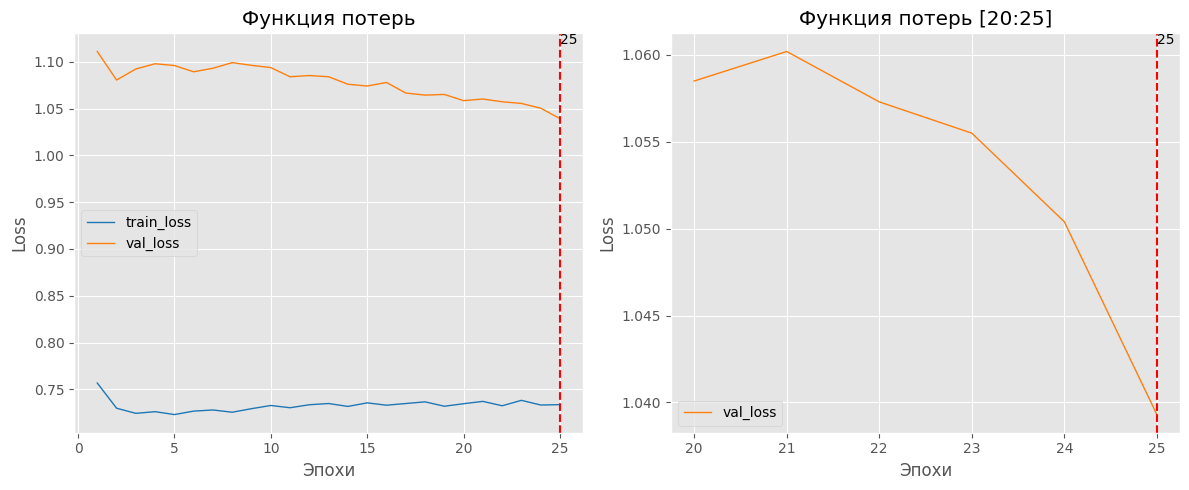

SAVING PLOTS COMPLETE...


In [300]:
# Вывод графиков метрик модели
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

axs[0].plot(df['epoch'], df['train_loss'],
            color='tab:blue', label='train_loss', linewidth=1)
axs[0].plot(df['epoch'], df['val_loss'],
            color='tab:orange', label='val_loss', linewidth=1)

axs[1].plot(selected_df['epoch'], selected_df['val_loss'],
            color='tab:orange', label='val_loss', linewidth=1)

axs[0].axvline(x=best_loss, color='red', linestyle='--')
axs[0].text(best_loss, axs[0].get_ylim()[1], str(best_loss),
            color='black', ha='left', va='top')
axs[0].set_xlabel('Эпохи')
axs[0].set_ylabel('Loss')
axs[0].set_title('Функция потерь')
axs[0].legend()

axs_title1 = 'Функция потерь [' + str(start_epoch) + ':' + str(end_epoch) + ']'
axs[1].axvline(x=best_loss, color='red', linestyle='--')
axs[1].text(best_loss, axs[1].get_ylim()[1], str(best_loss),
            color='black', ha='left', va='top')
axs[1].set_xlabel('Эпохи')
axs[1].set_ylabel('Loss')
axs[1].set_title(axs_title1)
axs[1].legend()

plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, 'loss.png'))
plt.show()
print('SAVING PLOTS COMPLETE...')

## 3.6 Оценка производительности моделей `PyTorch`

### 3.6.1 Получение истинных меток тестовой выборки

In [236]:
# Создание папки для сохранения файлов
ground_truth_dir = os.path.join(INFERENCE_DIR, 'ground_truth')
os.makedirs(os.path.join(ground_truth_dir), exist_ok=True)
# change directory to the one with the files to be changed
IMG_PATH = os.path.join(TEST_DIR, 'images')
GT_PATH  = os.path.join(TEST_DIR, 'labels')
# Обновляем путь для поиска .txt файлов
txt_list = glob.glob(os.path.join(GT_PATH, '*.txt'))

if len(txt_list) == 0:
    print("Error: no .txt files found in ground-truth")
    sys.exit()

for tmp_file in txt_list:
    # 1. check that there is an image with that name
    # get name before ".txt"
    image_name = os.path.basename(tmp_file).split(".txt", 1)[0]
    
    # check if image exists
    for fname in os.listdir(IMG_PATH):
        if fname.startswith(image_name):
            # image found
            img = cv2.imread(os.path.join(IMG_PATH, fname))
            # get image width and height
            img_height, img_width = img.shape[:2]
            break
    else:
        # image not found
        print("Error: image not found, corresponding to " + tmp_file)
        sys.exit()
    
    # 2. open txt file lines to a list
    with open(tmp_file) as f:
        content = f.readlines()
    
    # remove whitespace characters like `\n` at the end of each line
    content = [x.strip() for x in content]
    
    # 3. create new file (VOC format)
    with open(os.path.join(ground_truth_dir, os.path.basename(tmp_file)), "w") as new_f:
        for line in content:
            # split a line by spaces.
            # "c" stands for center and "n" stands for normalized
            obj_id, x_c_n, y_c_n, width_n, height_n = line.split()
            left, top, right, bottom = convert_yolo_coordinates_to_voc(x_c_n,
                                                                       y_c_n,
                                                                       width_n,
                                                                       height_n,
                                                                       img_width,
                                                                       img_height)
            # add new line to file
            ground_truth_line = f"{obj_id} {left} {top} {right} {bottom}"
            # print(os.path.basename(tmp_file), ' ', ground_truth_line)
            new_f.write(ground_truth_line + '\n')

print('Файлы истинных меток записаны в папку', ground_truth_dir)

Файлы истинных меток записаны в папку /home/igor/diplom/src/outputs/fasterrcnn_mobilenet_d8_e200a/inference/ground_truth


### 3.6.2 Получение предсказанных меток на тестовой выборке

In [237]:
# load the best model and trained weights
# model_best = create_model_ssd(num_classes=NUM_CLASSES, size=RESIZE_TO)
model_best = create_model(num_classes=NUM_CLASSES, model_name=MODEL)
checkpoint = torch.load(best_model_path, map_location=DEVICE)
model_best.load_state_dict(checkpoint['model_state_dict'])
model_best.to(DEVICE).eval()

detection_threshold = 0.01  # порог детектирования для 'mAP.py'
# Создание папки для сохранения файлов с результатами предсказания
detection_results_dir = os.path.join(INFERENCE_DIR, 'detection_results')
os.makedirs(os.path.join(detection_results_dir), exist_ok=True)

for tmp_file in txt_list:
    # 1. check that there is an image with that name
    # get name before ".txt"
    image_name = os.path.basename(tmp_file).split(".txt", 1)[0]
    
    # check if image exists
    for fname in os.listdir(IMG_PATH):
        if fname.startswith(image_name):
            # image found
            img = cv2.imread(os.path.join(IMG_PATH, fname))
            orig_img = img.copy()
            # BGR to RGB
            img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB).astype(np.float32)
            img /= 255.0  # make the pixel range between 0 and 1
            # bring color channels to front
            img = np.transpose(img, (2, 0, 1)).astype(np.float32)
            # convert to tensor
            img = torch.tensor(img, dtype=torch.float).cuda()
            # add batch dimension
            img = torch.unsqueeze(img, 0)
            # get image width and height
            img_height, img_width = img.shape[:2]
            
            # 2. get detection
            with torch.no_grad():
                outputs = model_best(img.to(DEVICE))
            
            # load all detection to CPU for further operations
            outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
            
            # carry further only if there are detected boxes
            if len(outputs[0]['boxes']) != 0:
                boxes = outputs[0]['boxes'].data.numpy()
                scores = outputs[0]['scores'].data.numpy()
                # filter out boxes according to `detection_threshold`
                boxes = boxes[scores >= detection_threshold].astype(np.int32)
                draw_boxes = boxes.copy()
                # get all the predicted class names
                pred_classes = [CLASSES[i] for i in outputs[0]['labels'].cpu().numpy()]
                
                # 3. create new file (VOC format)
                with open(os.path.join(detection_results_dir, f"{image_name}.txt"), 'w') as new_f:
                    for j, box in enumerate(draw_boxes):
                        class_id = outputs[0]['labels'][j].item()
                        left, top, right, bottom = [int(coord) for coord in box]
                        # add new line to file
                        detection_results_line = f'{int(class_id)-1} {scores[j]:.6f} {left} {top} {right} {bottom}'
                        # print(os.path.basename(tmp_file), ' ', detection_results_line)
                        new_f.write(detection_results_line + '\n')
            break
    else:
        # image not found
        print("Error: image not found, corresponding to " + tmp_file)
        sys.exit()

print('Файлы результатов предсказаний записаны в папку', detection_results_dir)

Файлы результатов предсказаний записаны в папку /home/igor/diplom/src/outputs/fasterrcnn_mobilenet_d8_e200a/inference/detection_results


### 3.6.3 Вычисление метрик с помощью `mAP-calculator`

https://github.com/shreejalt/mAP-calculator/

    Аргументы:
    -d DET, --det DET     Full path to detection results folder
    -g GT, --gt GT        Full path to ground truth folder
    -i IOU, --iou IOU     Calculate AP at a particular IoU
    -p POINTS, --points POINTS
                          Interpolation value: 0: Continues / 11: PascalVOC2012 Challenge
    -n NAMES, --names NAMES
                          Full path of file containing names of classes index wise
    -o OUTPUT, --output OUTPUT
                          File to dump the output
    -c CONFIDENCE, --confidence CONFIDENCE
                          Confidence at which Precision/Recall is calculated
    -ig, --ignore         Flag to ignore the difficult anotations
    --coco                COCO Standard of calculation

In [252]:
# %run mAP.py -d 'outputs/ssd300_vgg16_d8_e50a/inference/detection_results' -g 'outputs/ssd300_vgg16_d8_e50a/inference/ground_truth' -i 0.5 -p 11 -n class.names -o 'outputs/ssd300_vgg16_d8_e50a/inference/map_log' -c 0.01 --coco
# %run mAP.py -d 'outputs/fasterrcnn_resnet50_d8_e50/inference/detection_results' -g 'outputs/fasterrcnn_resnet50_d8_e50/inference/ground_truth' -i 0.5 -p 11 -n class.names -o 'outputs/fasterrcnn_resnet50_d8_e50/inference/map_log' -c 0.01 --coco
%run mAP.py -d 'outputs/fasterrcnn_mobilenet_d8_e25/inference/detection_results' -g 'outputs/fasterrcnn_mobilenet_d8_e25/inference/ground_truth' -i 0.5 -p 11 -n class.names -o 'outputs/fasterrcnn_mobilenet_d8_e25/inference/map_log' -c 0.01 --coco

Total number of classes specified in "class.names" file: 3
Processed Detections..!

Total Files : 200
Calculating on COCO standards: IoU[0.5,...,0.95] | Points: 101


100%|██████████| 3/3 [00:00<00:00, 100.12it/s]


+---------------+-------+----+-------+----+-----------+--------+----------+-----+-------+
| Class/IoU@0.5 |   AP  | TP |   FP  | FN | Precision | Recall | F1 Score | GTs |  Dets |
+---------------+-------+----+-------+----+-----------+--------+----------+-----+-------+
|    burglary   | 0.007 | 15 |  1243 | 70 |   0.012   | 0.176  |  0.022   |  85 |  1258 |
|    fighting   | 0.023 | 54 |  3783 | 22 |   0.014   | 0.711  |  0.028   |  76 |  3837 |
|    robbery    | 0.010 | 68 | 14745 | 26 |   0.005   | 0.723  |  0.009   |  94 | 14813 |
+---------------+-------+----+-------+----+-----------+--------+----------+-----+-------+
mAP@0.5: 0.0131 	mean F1 Score: 0.0197
+------------+------+------+------+------+------+------+------+------+------+------+
| class/IoU@ | 0.50 | 0.55 | 0.60 | 0.65 | 0.70 | 0.75 | 0.80 | 0.85 | 0.90 | 0.95 |
+------------+------+------+------+------+------+------+------+------+------+------+
|  burglary  | 0.01 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 

<Figure size 640x480 with 0 Axes>

## 3.7 Визуализация предсказания моделей `PyTorch`

### 3.7.1 Визуализация предсказания на тестовых изображениях

In [239]:
# directory where all the images are present
test_images = glob.glob(os.path.join(TEST_DIR, 'images', '*.jpg'))
print(f"Количество тестовых изображений: {len(test_images)}")

# Путь к папке для сохранения изображений
output_image_folder = os.path.join(INFERENCE_DIR, 'images')
print(f"Путь к папке с предсказанными изображениями {output_image_folder}")
# Проверяем существование папки и создаём, если её нет
if not os.path.exists(output_image_folder):
    os.makedirs(output_image_folder)

detection_threshold = 0.5  # порог детектирования
# detection_threshold = 0.15  # порог детектирования fasterrcnn_mobilenet_d8_e18
frame_count = 0  # to count the total number of images iterated through
total_fps = 0    # to keep adding the FPS for each image

Количество тестовых изображений: 200
Путь к папке с предсказанными изображениями /home/igor/diplom/src/outputs/fasterrcnn_mobilenet_d8_e200a/inference/images


In [240]:
for i in range(len(test_images)):
    # get the image file name for saving output later on
    image_name = test_images[i].split(os.path.sep)[-1].split('.')[0]
    image = cv2.imread(test_images[i])
    orig_image = image.copy()
    image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB).astype(np.float32)  # BGR to RGB
    image /= 255.0  # make the pixel range between 0 and 1
    image = np.transpose(image, (2, 0, 1)).astype(np.float32)  # bring color channels to front
    image = torch.tensor(image, dtype=torch.float).cuda()  # convert to tensor
    image = torch.unsqueeze(image, 0)  # add batch dimension
    
    start_time = time.time()  # get the start time
    with torch.no_grad():
        outputs = model_best(image.to(DEVICE))
    end_time = time.time()
    fps = 1 / (end_time - start_time)  # get the current fps
    total_fps += fps  # add `fps` to `total_fps`
    frame_count += 1  # increment frame count
    
    # load all detection to CPU for further operations
    outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
        
    # carry further only if there are detected boxes
    if len(outputs[0]['boxes']) != 0:
        boxes = outputs[0]['boxes'].data.numpy()
        scores = outputs[0]['scores'].data.numpy()
        
        # filter out boxes according to `detection_threshold`
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        draw_boxes = boxes.copy()
        
        # get all the predicited class names
        pred_classes = [CLASSES[i] for i in outputs[0]['labels'].cpu().numpy()]
        
        # draw the bounding boxes and write the class name on top of it
        for j, box in enumerate(draw_boxes):
            class_name = pred_classes[j]
            color = tuple(int(c) for c in COLORS[CLASSES.index(class_name)])
            cv2.rectangle(orig_image,
                          (int(box[0]), int(box[1])),
                          (int(box[2]), int(box[3])),
                          color, 2)
            put_text = str(class_name) + str(round(scores[j], 1))
            cv2.putText(orig_image, put_text, 
                        (int(box[0]), int(box[1]-5)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 
                        2, lineType=cv2.LINE_AA)
        
        cv2.imshow('Prediction', orig_image)
        cv2.waitKey(1)
        cv2.imwrite(f"{output_image_folder}/{image_name}.jpg", orig_image)
    
    print(f"Image {i+1} done...")
    print('-'*50)

print('TEST PREDICTIONS COMPLETE')
cv2.destroyAllWindows()  # close all frame windows
avg_fps = total_fps / frame_count  # calculate and print the average FPS
print(f'Средний FPS: {avg_fps:.4f}')

# Чтение данных из файла map_log.csv
map_log_file = os.path.join(INFERENCE_DIR, 'map_log.csv')

with open(map_log_file, mode='r') as map_file:
    reader = csv.reader(map_file)
    next(reader)  # Пропускаем заголовок
    
    for row in reader:
        mf1_score50 = float(row[0])
        mAP50 = float(row[1])
        mAP95 = float(row[2])

# Запись данных в файл CSV
with open(image_inference_out, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['model_name', 'images_num', 'mF1_score50', 'mAP50', 'mAP50-95', 'average_fps'])
    writer.writerow([MODEL, len(test_images), mf1_score50, mAP50, mAP95, f'{avg_fps:.4f}'])
    print('Файл', image_inference_out, 'записан')

Image 1 done...
--------------------------------------------------
Image 2 done...
--------------------------------------------------
Image 3 done...
--------------------------------------------------
Image 4 done...
--------------------------------------------------
Image 5 done...
--------------------------------------------------
Image 6 done...
--------------------------------------------------
Image 7 done...
--------------------------------------------------
Image 8 done...
--------------------------------------------------
Image 9 done...
--------------------------------------------------
Image 10 done...
--------------------------------------------------
Image 11 done...
--------------------------------------------------
Image 12 done...
--------------------------------------------------
Image 13 done...
--------------------------------------------------
Image 14 done...
--------------------------------------------------
Image 15 done...
----------------------------------------

### 3.7.2 Визуализация предсказания на видео не из датасета

In [241]:
# Open the video file
# video_file = 'gettyimages-450062442-640_adpp.mp4'
# video_file = 'gettyimages-450065798-640_adpp.mp4'
# video_file = 'gettyimages-159818553-640_adpp.mp4'
video_file = 'gettyimages-162882796-640_adpp.mp4'
video_path = os.path.join(current_dir, video_file)
video_name = video_path.split(os.path.sep)[-1].split('.')[0]

detection_threshold = 0.5  # порог детектирования
# detection_threshold = 0.15  # порог детектирования fasterrcnn_mobilenet_d8_e18
RESIZE_LIST = (RESIZE_TO, RESIZE_TO)
cap = cv2.VideoCapture(video_path)

if (cap.isOpened() == False):
    print('Error while trying to read video. Please check path again')

# Путь к папке для сохранения видео
output_video_folder = os.path.join(INFERENCE_DIR, 'videos')
# Проверяем существование папки и создаём, если её нет
if not os.path.exists(output_video_folder):
    os.makedirs(output_video_folder)

# define codec and create VideoWriter object 
out = cv2.VideoWriter(f"{output_video_folder}/{video_name}.mp4", 
                      cv2.VideoWriter_fourcc(*'mp4v'), 30, RESIZE_LIST)
frame_count = 0  # to count total frames
total_fps = 0    # to get the final frames per second

In [242]:
# read until end of video
while(cap.isOpened()):
    success, frame = cap.read()  # capture each frame of the video
    
    if success:
        frame = cv2.resize(frame, RESIZE_LIST)
        image = frame.copy()
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0  # make the pixel range between 0 and 1
        # bring color channels to front
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        image = torch.tensor(image, dtype=torch.float).cuda()  # convert to tensor
        image = torch.unsqueeze(image, 0)  # add batch dimension
        
        start_time = time.time()  # get the start time
        with torch.no_grad():
            # get predictions for the current frame
            outputs = model_best(image.to(DEVICE))
        end_time = time.time()
        fps = 1 / (end_time - start_time)  # get the current fps
        total_fps += fps  # add `fps` to `total_fps`
        frame_count += 1  # increment frame count
        
        # load all detection to CPU for further operations
        outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
        
        # carry further only if there are detected boxes
        if len(outputs[0]['boxes']) != 0:
            boxes = outputs[0]['boxes'].data.numpy()
            scores = outputs[0]['scores'].data.numpy()
            # filter out boxes according to `detection_threshold`
            boxes = boxes[scores >= detection_threshold].astype(np.int32)
            draw_boxes = boxes.copy()
            # get all the predicited class names
            pred_classes = [CLASSES[i] for i in outputs[0]['labels'].cpu().numpy()]
            
            # draw the bounding boxes and write the class name on top of it
            for j, box in enumerate(draw_boxes):
                class_name = pred_classes[j]
                color = tuple(int(c) for c in COLORS[CLASSES.index(class_name)])
                cv2.rectangle(frame,
                              (int(box[0]), int(box[1])),
                              (int(box[2]), int(box[3])),
                              color, 2)
                put_text = str(class_name) + str(round(scores[j], 1))
                cv2.putText(frame, put_text,
                            (int(box[0]), int(box[1]-5)),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7,
                            color, 2, lineType=cv2.LINE_AA)
        
        cv2.putText(frame, f"{fps:.1f} FPS",
                    (10, 25),
                    cv2.FONT_HERSHEY_SIMPLEX, 1,
                    (0, 255, 0), 2, lineType=cv2.LINE_AA)
        cv2.imshow('Faster R-CNN Inference', frame)
        out.write(frame)
        
        # Break the loop if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break
    else:
        # Break the loop if the end of the video is reached
        break

# Release the video capture object and close the display window
cap.release()
cv2.destroyAllWindows() # чтобы окно CV2 не зависало
print('Файл', video_file, 'записан')

avg_fps = total_fps / frame_count  # вычисление среднего FPS
print(f'Средний FPS: {avg_fps:.4f}')
    
# Запись данных в файл CSV
with open(video_inference_out, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['model_name', 'video_name', 'average_fps'])
    writer.writerow([MODEL, video_file, f'{avg_fps:.4f}'])
    print('Файл', video_inference_out, 'записан')

Файл gettyimages-162882796-640_adpp.mp4 записан
Средний FPS: 46.2911
Файл /home/igor/diplom/src/outputs/fasterrcnn_mobilenet_d8_e200a/inference/video_inference.csv записан


## 3.8 Экспорт моделей `PyTorch` и очистка видеокэша

### 3.8.1 Экспорт лучшей модели `PyTorch` в файл формата `ONNX`

In [243]:
# Создание фиктивного входного тензора,
# который будет использоваться для экспорта модели
dummy_input = torch.randn(1, 3, RESIZE_TO, RESIZE_TO, device=DEVICE)

# Экспорт модели `YOLOv9` в файл формата `ONNX`
torch.onnx.export(model_best, dummy_input, os.path.join(OUT_DIR, 'best_model.onnx'))
print('Файл "best_model.onnx" записан')

Файл "best_model.onnx" записан


### 3.8.2 Очистка видеокэша `PyTorch`

In [244]:
torch.cuda.empty_cache()

# 4. Сравнение метрик моделей

## 4.1 Считывание метрик моделей

In [14]:
# Создание словаря inference
inference = {key: os.path.join(current_dir, 'runs', 'detect', key, 'inference', 'test_inference.csv') for key in models}
inference.update(results_path_pt)  # добавление моделей PyTorch

# Чтение данных из файлов и объединение их в один датафрейм
dataframe = []
for model, file_path in inference.items():
    dfs = pd.read_csv(file_path)
    dfs['model_name'] = model
    dataframe.append(dfs)

df = pd.concat(dataframe, ignore_index=True)
df = df.round(3)  # округляем для удобства вывода

# Вывод результирующего датафрейма
df

,model_name,images_num,mF1_score50,mAP50,mAP50-95,average_fps,params_M,flops_B
0,yolov9c_d7_e300,200,0.827,0.870,0.603,30.647,25.5,103.70
1,fasterrcnn_resnet50_d8_e50,200,0.014,0.009,0.003,12.749,41.8,134.80
2,fasterrcnn_mobilenet_d8_e18,200,0.035,0.029,0.013,49.296,19.4,4.49
3,ssd300_vgg16_d8_e15,200,0.007,0.063,0.023,59.270,35.6,34.86


## 4.2 Визуализация метрик моделей

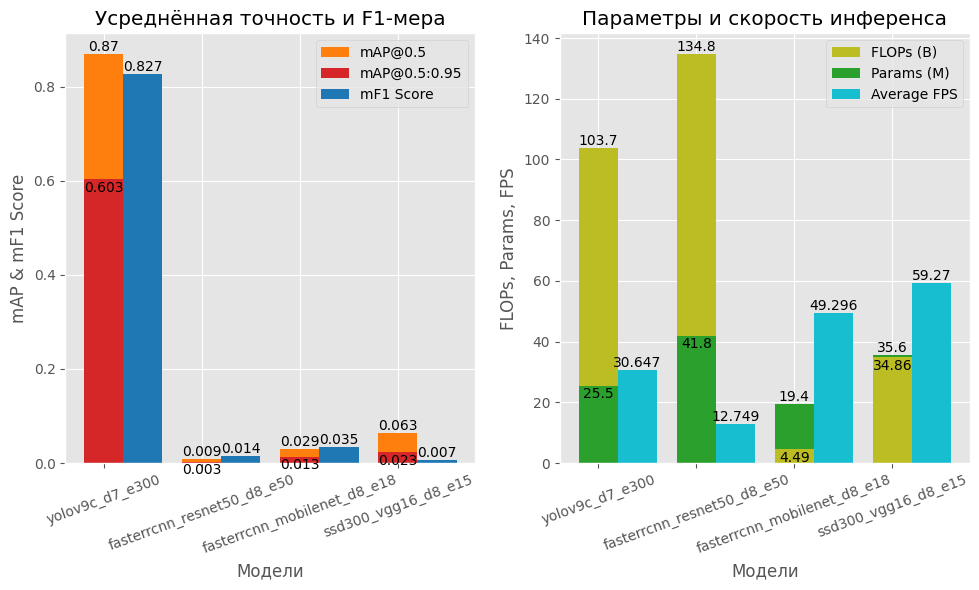

SAVING PLOTS COMPLETE...


In [73]:
# Вывод графиков тестовых метрик для каждой модели
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

index = np.arange(len(inference))  # число моделей !!!
bw = 0.4
rects1 = axs[0].bar(df['model_name'], df['mAP50'], bw, color='tab:orange', label='mAP@0.5')
rects2 = axs[0].bar(df['model_name'], df['mAP50-95'], bw, color='tab:red', label='mAP@0.5:0.95')
rects3 = axs[0].bar(index+bw, df['mF1_score50'], bw, color='tab:blue', label='mF1 Score')
axs[0].set_xlabel('Модели')
axs[0].set_ylabel('mAP & mF1 Score')
axs[0].tick_params(axis='x', labelrotation = 20)
axs[0].bar_label(rects1, padding=0, fontsize=10)
axs[0].bar_label(rects2, padding=-11, fontsize=10)
axs[0].bar_label(rects3, padding=0, fontsize=10)
axs[0].set_title('Усреднённая точность и F1-мера')
axs[0].legend(loc='best')

rects4 = axs[1].bar(df['model_name'][:2], df['flops_B'][:2], bw, color='tab:olive', label='FLOPs (B)')
rects5 = axs[1].bar(df['model_name'][:2], df['params_M'][:2], bw, color='tab:green', label='Params (M)')
rects6 = axs[1].bar(df['model_name'][2:], df['params_M'][2:], bw, color='tab:green')
rects7 = axs[1].bar(df['model_name'][2:], df['flops_B'][2:], bw, color='tab:olive')
rects8 = axs[1].bar(index+bw, df['average_fps'], bw, color='tab:cyan', label='Average FPS')
axs[1].set_xlabel('Модели')
axs[1].set_ylabel('FLOPs, Params, FPS')
axs[1].tick_params(axis='x', labelrotation = 20)
axs[1].bar_label(rects4, padding=0, fontsize=10)
axs[1].bar_label(rects5, padding=-11, fontsize=10)
axs[1].bar_label(rects6, padding=0, fontsize=10)
axs[1].bar_label(rects7, padding=-11, fontsize=10)
axs[1].bar_label(rects8, padding=0, fontsize=10)
axs[1].set_title('Параметры и скорость инференса')
axs[1].legend(loc='best')

plt.tight_layout()
plt.savefig(os.path.join(current_dir, 'models_compare.png'))
plt.show()
print('SAVING PLOTS COMPLETE...')

# 5. Цитаты и благодарности

**BibTeX**
```
@article{
    wang2024yolov9,
    title = { { YOLOv9 }: Learning What You Want to Learn Using Programmable Gradient Information },
    author = { Wang, Chien-Yao and Liao, Hong-Yuan Mark },
    booktitle = { arXiv preprint arXiv: 2402.13616 },
    year = { 2024 }
}
```